In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import emcee

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [2]:
def computeResponse(delta,length,width,time,u,k_0,R):
        """
        Computes concentrations.
        Arguments:
         source == forcing function (shape: Nt x Nx x Ny). Can either be generated by ... or determine manually.
         enforce_nonnegative = default False,. Setting to true will force concentration to be non-negative each iteration.
        returns array of concentrations (shape: Nt x Nx x Ny), given source. (also saved it in self.concentration)
        """
        #source = self.source
        
        #get the grid step sizes, their squares and the size of the grid
        
        dt = delta[0]
        dx = delta[1]
        dy = delta[2]
        dx2 = dx**2
        dy2 = dy**2
        Nt = int(time/dt)
        Nx = int(length/dx)
        Ny = int(width/dy)
        c=np.zeros((Nt,Nx,Ny))
        
        source = np.zeros((Nt,Nx,Ny))
        u=[u[0]*np.ones((Nt,Nx,Ny)),u[1]*np.ones((Nt,Nx,Ny))]
        source[0,int(Nx/10),int(Ny/10)]=1000
        
        c[0,:,:]=0
        for i in range(0,Nt-1):
            # Corner BCs 
            c[i+1,0,0]=c[i,0,0]+dt*( source[i,0,0] ) +dt*k_0*( 2*c[i,1,0]-2*c[i,0,0])/dx2 + dt*k_0*( 2*c[i,0,1]-2*c[i,0,0])/dy2 -dt*R*c[i,0,0]
            c[i+1,Nx-1,Ny-1]=c[i,Nx-1,Ny-1]+dt*( source[i,Nx-1,Ny-1])+dt*k_0*( 2*c[i,Nx-2,Ny-1]-2*c[i,Nx-1,Ny-1])/dx2 + dt*k_0*( 2*c[i,Nx-1,Ny-2]-2*c[i,Nx-1,Ny-1])/dy2-dt*R*c[i,Nx-1,Ny-1]
            c[i+1,0,Ny-1]=c[i,0,Ny-1]+dt*( source[i,0,Ny-1] ) +dt*k_0*( 2*c[i,1,Ny-1]-2*c[i,0,Ny-1])/dx2 + dt*k_0*( 2*c[i,0,Ny-2]-2*c[i,0,Ny-1])/dy2-dt*R*c[i,0,Ny-1]
            c[i+1,Nx-1,0]=c[i,Nx-1,0]+dt*( source[i,Nx-1,0])+dt*k_0*( 2*c[i,Nx-2,0]-2*c[i,Nx-1,0])/dx2 + dt*k_0*( 2*c[i,Nx-1,1]-2*c[i,Nx-1,0])/dy2-dt*R*c[i,Nx-1,0]
    
            c[i+1,1:Nx-1,0]=c[i,1:Nx-1,0]+dt*(source[i,1:Nx-1,0]-u[0][i,1:Nx-1,0]*(c[i,2:Nx,0]-c[i,0:Nx-2,0])/(2*dx)+k_0*(2*c[i,1:Nx-1,1]-2*c[i,1:Nx-1,0])/dy2 +k_0*(c[i,2:Nx,0]-2*c[i,1:Nx-1,0]+c[i,0:Nx-2,0] )/dx2 - R*c[i,1:Nx-1,0]     )
            c[i+1,1:Nx-1,Ny-1]=c[i,1:Nx-1,Ny-1]+dt*( source[i,1:Nx-1,Ny-1]-u[0][i,1:Nx-1,Ny-1]*(c[i,2:Nx,Ny-1]-c[i,0:Nx-2,Ny-1])/(2*dx)+k_0*(2*c[i,1:Nx-1,Ny-2]-2*c[i,1:Nx-1,Ny-1])/dy2 +k_0*(c[i,2:Nx,Ny-1]-2*c[i,1:Nx-1,Ny-1]+c[i,0:Nx-2,Ny-1] )/dx2 - R*c[i,1:Nx-1,Ny-1]     )  
            #for k in range(1,Ny-1):
                # x edge bcs
            c[i+1,Nx-1,1:Ny-1]=c[i,Nx-1,1:Ny-1]+dt*( source[i,Nx-1,1:Ny-1]-u[1][i,Nx-1,1:Ny-1]*(c[i,Nx-1,2:Ny]-c[i,Nx-1,0:Ny-2])/(2*dy)+k_0*(2*c[i,Nx-2,1:Ny-1]-2*c[i,Nx-1,1:Ny-1])/dx2 +k_0*(c[i,Nx-1,2:Ny]-2*c[i,Nx-1,1:Ny-1]+c[i,Nx-1,0:Ny-2] )/dy2  - R*c[i,Nx-1,1:Ny-1]   )
            c[i+1,0,1:Ny-1]=c[i,0,1:Ny-1]+dt*( source[i,0,1:Ny-1]-u[1][i,0,1:Ny-1]*(c[i,0,2:Ny]-c[i,0,0:Ny-2])/(2*dy)+k_0*(2*c[i,1,1:Ny-1]-2*c[i,0,1:Ny-1])/dx2 +k_0*(c[i,0,2:Ny]-2*c[i,0,1:Ny-1]+c[i,0,0:Ny-2] )/dy2 - R*c[i,0,1:Ny-1]    )     
                # Internal Calc
            c[i+1,1:Nx-1,1:Ny-1]=c[i,1:Nx-1,1:Ny-1] +dt*(source[i,1:Nx-1,1:Ny-1]-u[0][i,1:Nx-1,1:Ny-1]*(c[i,2:Nx,1:Ny-1]-c[i,0:Nx-2,1:Ny-1])/(2*dx) -u[1][i,1:Nx-1,1:Ny-1]*(c[i,1:Nx-1,2:Ny]-c[i,1:Nx-1,0:Ny-2] )/(2*dy) +k_0*(c[i,2:Nx,1:Ny-1]-2*c[i,1:Nx-1,1:Ny-1]  +c[i,0:Nx-2,1:Ny-1])/dx2+k_0*(c[i,1:Nx-1,2:Ny]-2*c[i,1:Nx-1,1:Ny-1]  +c[i,1:Nx-1,0:Ny-2])/dy2 - R*c[i,1:Nx-1,1:Ny-1])

        return c     

In [3]:
def computeResponse(delta,length,width,time,u,k_0,R):
        """
        Computes concentrations.
        Arguments:
         source == forcing function (shape: Nt x Nx x Ny). Can either be generated by ... or determine manually.
         enforce_nonnegative = default False,. Setting to true will force concentration to be non-negative each iteration.
        returns array of concentrations (shape: Nt x Nx x Ny), given source. (also saved it in self.concentration)
        """
        #source = self.source
        
        #get the grid step sizes, their squares and the size of the grid
        
        dt = delta[0]
        dx = delta[1]
        dy = delta[2]
        dx2 = dx**2
        dy2 = dy**2
        Nt = int(time/dt)
        Nx = int(length/dx)
        Ny = int(width/dy)
        c=np.zeros((Nt,Nx,Ny))
        
        source = np.zeros((Nt,Nx,Ny))
        u=[u[0]*np.ones((Nt,Nx,Ny)),u[1]*np.ones((Nt,Nx,Ny))]
        source[0,int(Nx/100),int(Ny/100)]=1000
        
        c[0,:,:]=0
        for i in range(0,Nt-1):
            # Corner BCs 
            c[i+1,0,0]=0
            c[i+1,Nx-1,Ny-1]=0
            c[i+1,0,Ny-1]=0
            c[i+1,Nx-1,0]=0
    
            c[i+1,1:Nx-1,0]=0
            c[i+1,1:Nx-1,Ny-1]=0 
            #for k in range(1,Ny-1):
                # x edge bcs
            c[i+1,Nx-1,1:Ny-1]=0
            c[i+1,0,1:Ny-1]=0
                # Internal Calc
            c[i+1,1:Nx-1,1:Ny-1]=c[i,1:Nx-1,1:Ny-1] +dt*(source[i,1:Nx-1,1:Ny-1]-u[0][i,1:Nx-1,1:Ny-1]*(c[i,2:Nx,1:Ny-1]-c[i,0:Nx-2,1:Ny-1])/(2*dx) -u[1][i,1:Nx-1,1:Ny-1]*(c[i,1:Nx-1,2:Ny]-c[i,1:Nx-1,0:Ny-2] )/(2*dy) +k_0*(c[i,2:Nx,1:Ny-1]-2*c[i,1:Nx-1,1:Ny-1]  +c[i,0:Nx-2,1:Ny-1])/dx2+k_0*(c[i,1:Nx-1,2:Ny]-2*c[i,1:Nx-1,1:Ny-1]  +c[i,1:Nx-1,0:Ny-2])/dy2 - R*c[i,1:Nx-1,1:Ny-1])

        return c  

In [4]:
adr=computeResponse([0.002,0.01,0.01],1,1,10,[0.1,0.1],0.001,0)

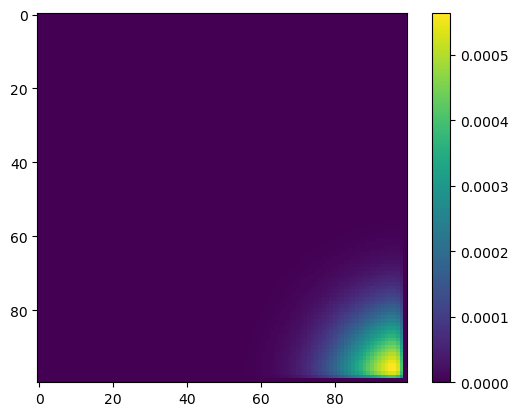

In [5]:
plt.imshow(adr[-1])
plt.colorbar()

In [6]:
np.sum(adr,axis=(1,2))

array([0.        , 2.        , 1.96      , ..., 0.13471968, 0.13434244,
       0.13396595])

In [7]:
10/0.1

100.0

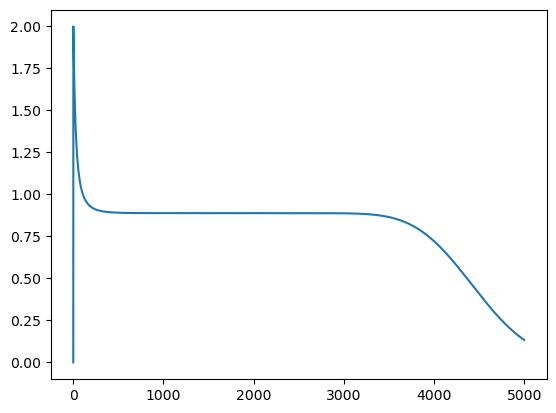

In [8]:
plt.plot(np.sum(adr,axis=(1,2)))

In [9]:
def computeResponse(dt,time,impulse,theta):        
        """
        Computes the system response over time (returns a vector)
        Arguments:
        source == forcing function (shape: Nt). Can either be generated by ... or determine manually.
        returns array of concentrations (shape: Nt), given source. (also saved it in self.conc)
        """
  
        Nt = int(time/dt)
        dt2 = dt**2
        
        x=np.zeros((Nt))
        source=np.zeros((Nt))
        source[0]=impulse
        
        k_0,u,eta = theta

        x[0] = 0
        #x[1] = 0
        x[1] = ( 1.0/(-k_0+u*dt/2))*(k_0*(-2*x[0] + x[0] )+  (u*dt*x[0])/2.0- eta*x[0]*(dt2)+ source[0]*(dt2))
        for i in range(1, Nt-1):
            x[i+1] = ( 1.0/(-k_0+u*dt/2))*(k_0*(-2*x[i] + x[i-1] )+  (u*dt*x[i-1])/2.0- eta*x[i]*(dt2)+ source[i]*(dt2))
        

        return x

In [10]:
oscillator = computeResponse(0.01,1.5,1,[-0.5,0.5,0.1])

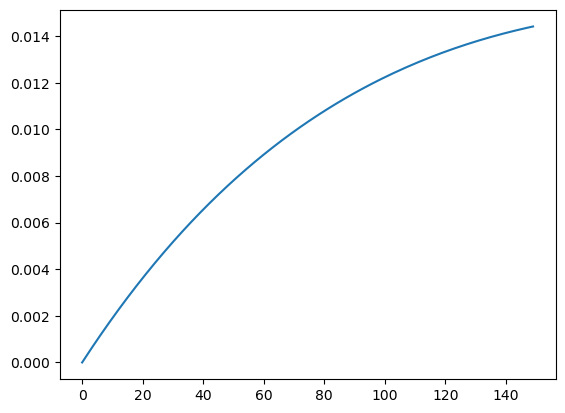

In [11]:
plt.plot(oscillator)

In [12]:
import scipy.stats.qmc as qmc

In [13]:
theta_sampler = qmc.LatinHypercube(d=3)
theta_sample = theta_sampler.random(n=180)

In [14]:
l_bounds = [-2,0,0]
u_bounds = [-0.1, 2,2]
theta = qmc.scale(theta_sample, l_bounds, u_bounds)

In [15]:
latent_sampler = qmc.LatinHypercube(d=2)
latent_sample = latent_sampler.random(n=18)

In [16]:
l_bounds = [1,1]
u_bounds = [10,100]
latent = qmc.scale(latent_sample, l_bounds, u_bounds)

In [17]:
y = np.zeros(180)
for i in range(180):
    y[i]=computeResponse(0.01,5,1,theta[i]).mean()
    

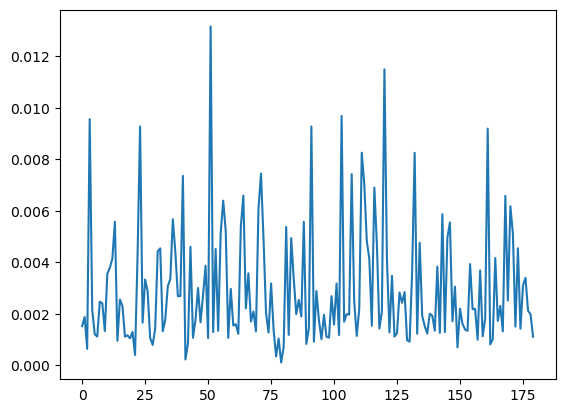

In [18]:
plt.plot(y)

In [19]:
# split original dataset in training, validation and testing sets
X=torch.tensor(theta)
y=torch.tensor(y)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=seed
)

In [20]:
emulator=GPE.ensemble(X_train,y_train[:,None],mean_func='linear')

0


In [21]:
emulator.R2(X_test,y_test[:,None])

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:208: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_score=1-self.MSE(inputVals,outputVals)/torch.tensor(torch.var(outputVals,axis=0))


tensor([0.9595], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [22]:
latent

array([[ 8.33018313, 13.49025015],
       [ 7.35017641, 73.56206311],
       [ 9.52672745, 97.39486655],
       [ 6.59588915, 91.14495589],
       [ 6.21235478, 86.46242465],
       [ 2.55906099, 18.93350995],
       [ 4.82230922, 10.99017059],
       [ 9.35946918, 30.06174259],
       [ 3.5966401 , 55.24386774],
       [ 8.54835852, 45.61890822],
       [ 5.17050313,  5.09655133],
       [ 4.01523671, 82.58485002],
       [ 2.29078501, 62.805355  ],
       [ 5.89964218, 61.45456922],
       [ 1.11139346, 34.83760112],
       [ 7.742141  , 67.47847073],
       [ 3.28594304, 42.53758167],
       [ 1.8315365 , 26.85169167]])

In [23]:
inputs=[]
for i,l in enumerate(latent):
    theta_sampler = qmc.LatinHypercube(d=3)
    theta_sample = theta_sampler.random(n=180)
    l_bounds = [-2,0,0]
    u_bounds = [-0.1, 2,2]
    theta = qmc.scale(theta_sample, l_bounds, u_bounds)
    inputs.append(theta)

In [24]:
outputs = []
for i,l in enumerate(latent):
    outputs.append([])
    for j in range(180):
        #outputs[i].append(computeResponse(0.01,l,inputs[i][j]).mean())
        #outputs[i].append(computeResponse(0.01,l,inputs[i][j])[-1])
        response = computeResponse(0.01,l[0],l[1],inputs[i][j])
        outputs[i].append([response.max()-response.min(),response[-1],response.mean()])

In [25]:
latent

array([[ 8.33018313, 13.49025015],
       [ 7.35017641, 73.56206311],
       [ 9.52672745, 97.39486655],
       [ 6.59588915, 91.14495589],
       [ 6.21235478, 86.46242465],
       [ 2.55906099, 18.93350995],
       [ 4.82230922, 10.99017059],
       [ 9.35946918, 30.06174259],
       [ 3.5966401 , 55.24386774],
       [ 8.54835852, 45.61890822],
       [ 5.17050313,  5.09655133],
       [ 4.01523671, 82.58485002],
       [ 2.29078501, 62.805355  ],
       [ 5.89964218, 61.45456922],
       [ 1.11139346, 34.83760112],
       [ 7.742141  , 67.47847073],
       [ 3.28594304, 42.53758167],
       [ 1.8315365 , 26.85169167]])

In [26]:
np.array(outputs)[15][:,1].var()

0.04378009700143026

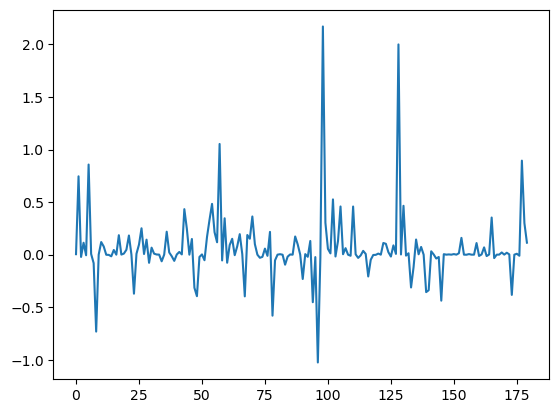

In [27]:
plt.plot(np.array(outputs)[1][:,1])

In [28]:
R2_mean = np.zeros((3,len(inputs)) )
R2_std = np.zeros((3,len(inputs))) 
for i in range(len(inputs)):
    
    # split original dataset in training, validation and testing sets
    X=torch.tensor(inputs[i]).float()
    y=torch.tensor(outputs[i]).float()
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.1,
        random_state=seed
    )
    emulator=GPE.ensemble(X_train,y_train,mean_func='linear')
    mean,std=emulator.R2_sample(X_test,y_test,1000)
    R2_mean[:,i]=mean
    R2_std[:,i]=std

0
1
2


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:187: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  prediction=torch.stack(prediction).T
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:216: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:217: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone(

0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2


In [29]:
1-((emulator.predict(X_test)-y_test)**2).mean()/y_test.var()

tensor(0.9365, grad_fn=<RsubBackward1>)

In [30]:
y_test

tensor([[ 0.1544,  0.1544,  0.0996],
        [ 0.1133,  0.1122,  0.0807],
        [ 0.1010,  0.0988,  0.0747],
        [ 0.2884, -0.0587,  0.0989],
        [ 0.1206,  0.1206,  0.0859],
        [ 0.2023,  0.1233,  0.1607],
        [ 0.1862,  0.1862,  0.1118],
        [ 0.2850,  0.1412,  0.2084],
        [ 0.0841,  0.0701,  0.0651],
        [ 0.1320,  0.1095,  0.0985],
        [ 0.1008,  0.0812,  0.0764],
        [ 0.1148,  0.0449,  0.0830],
        [ 0.1743,  0.1313,  0.1430],
        [ 0.1634,  0.0790,  0.1224],
        [ 0.1716,  0.1716,  0.1158],
        [ 0.0966,  0.0915,  0.0716],
        [ 0.1167,  0.1116,  0.0875],
        [ 0.1894,  0.0859,  0.1360]])

In [31]:
mean

tensor([0.2603, 0.2243, 0.2903])

In [32]:
R2_mean

array([[ 0.56414968,  0.58820128,  0.75600529,  0.59434909,  0.72367722,
        -0.1247089 ,  0.65558285,  0.67022085,  0.88937783,  0.54426527,
         0.68960178,  0.71735227,  0.54802412,  0.64008749,  0.7162289 ,
         0.78298205,  0.35661852,  0.26026163],
       [-0.35673925, -0.91653389, -0.32891262, -2.14101005,  0.68735147,
        -0.30583176,  0.2443222 , -0.45583263,  0.81976223,  0.22147864,
         0.25409424,  0.80680686,  0.75250727,  0.53357464,  0.30144864,
         0.57812315,  0.47081238,  0.22425646],
       [ 0.37206116,  0.3689281 ,  0.56033581,  0.50703943,  0.84883022,
         0.30593285,  0.67831457,  0.48812404,  0.86107618,  0.82633555,
         0.4570061 ,  0.87697697,  0.35252184,  0.30788699,  0.84324783,
         0.37872246,  0.37373909,  0.29029757]])

In [33]:
R2_mean.T[:,[0,2]]

array([[ 0.56414968,  0.37206116],
       [ 0.58820128,  0.3689281 ],
       [ 0.75600529,  0.56033581],
       [ 0.59434909,  0.50703943],
       [ 0.72367722,  0.84883022],
       [-0.1247089 ,  0.30593285],
       [ 0.65558285,  0.67831457],
       [ 0.67022085,  0.48812404],
       [ 0.88937783,  0.86107618],
       [ 0.54426527,  0.82633555],
       [ 0.68960178,  0.4570061 ],
       [ 0.71735227,  0.87697697],
       [ 0.54802412,  0.35252184],
       [ 0.64008749,  0.30788699],
       [ 0.7162289 ,  0.84324783],
       [ 0.78298205,  0.37872246],
       [ 0.35661852,  0.37373909],
       [ 0.26026163,  0.29029757]])

Text(0.5, 0, 'end time')

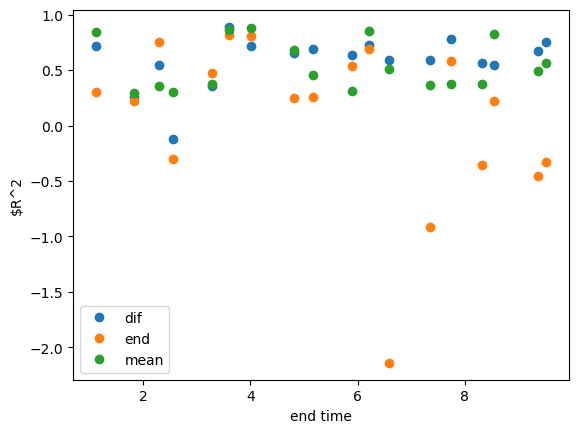

In [34]:
plt.plot(latent[:,0],R2_mean.T[:,[0,1,2]],'o')
plt.legend(['dif','end','mean'])
plt.ylabel('$R^2')
plt.xlabel('end time')

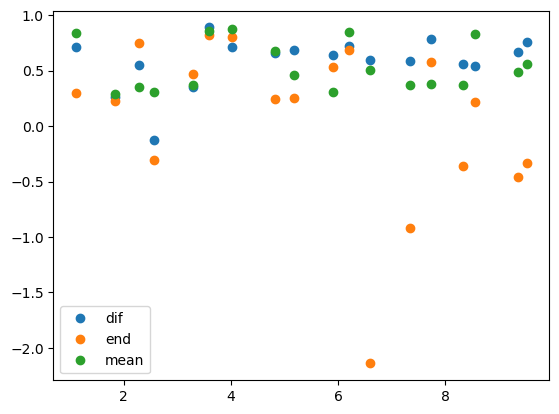

In [35]:
plt.plot(latent[:,0],R2_mean.T,'o')
plt.legend(['dif','end','mean'])

In [36]:
R2_mean = np.zeros((3,len(inputs)) )
MSE = np.zeros((3,len(inputs))) 
for i in range(len(inputs)):
    
    # split original dataset in training, validation and testing sets
    X=torch.tensor(inputs[i]).float()
    y=torch.tensor(outputs[i]).float()
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.1,
        random_state=seed
    )
    emulator=GPE.ensemble(X_train,y_train,mean_func='linear')
    mean=emulator.R2(X_test,y_test)
    R2_mean[:,i]=mean.detach().numpy()
    MSE[:,i]=emulator.MSE(X_test,y_test).detach().numpy()

0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2


Text(0.5, 0, 'end time')

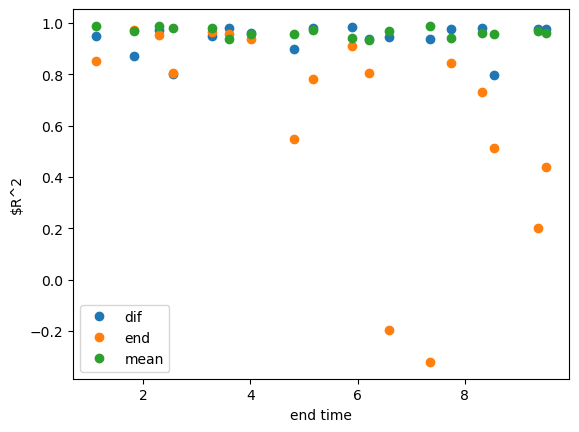

In [37]:
plt.plot(latent[:,0],R2_mean.T[:,[0,1,2]],'o')
plt.legend(['dif','end','mean'])
plt.ylabel('$R^2')
plt.xlabel('end time')

Text(0.5, 0, 'end time')

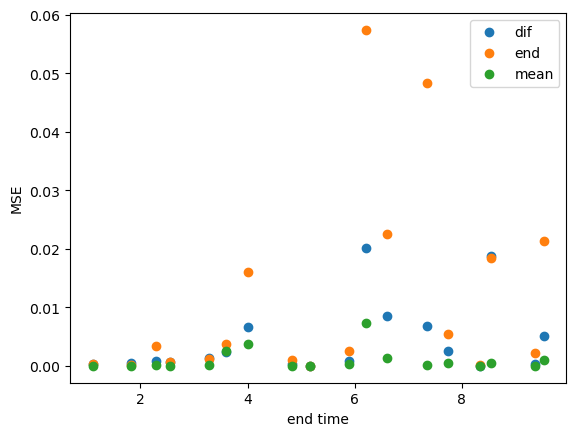

In [38]:
plt.plot(latent[:,0],MSE.T[:,[0,1,2]],'o')
plt.legend(['dif','end','mean'])
plt.ylabel('MSE')
plt.xlabel('end time')

In [39]:
80*0.05

4.0

In [40]:
large_input = np.array(inputs[0:17]).reshape(17*180,3)

In [41]:
latent[0:17]

array([[ 8.33018313, 13.49025015],
       [ 7.35017641, 73.56206311],
       [ 9.52672745, 97.39486655],
       [ 6.59588915, 91.14495589],
       [ 6.21235478, 86.46242465],
       [ 2.55906099, 18.93350995],
       [ 4.82230922, 10.99017059],
       [ 9.35946918, 30.06174259],
       [ 3.5966401 , 55.24386774],
       [ 8.54835852, 45.61890822],
       [ 5.17050313,  5.09655133],
       [ 4.01523671, 82.58485002],
       [ 2.29078501, 62.805355  ],
       [ 5.89964218, 61.45456922],
       [ 1.11139346, 34.83760112],
       [ 7.742141  , 67.47847073],
       [ 3.28594304, 42.53758167]])

In [42]:
large_input.shape

(3060, 3)

In [43]:
modeweights1 = np.repeat(latent[0:17,0],180)

In [44]:
modeweights2= np.repeat(latent[0:17,1],180)

In [45]:
large_input = np.concatenate((large_input,modeweights1[:,None],modeweights2[:,None]),axis=1)

In [46]:
large_output = np.array(outputs[0:17]).reshape(17*180,3)

In [47]:
leftout_input = np.concatenate((inputs[17],np.repeat(latent[17,0],180)[:,None],np.repeat(latent[17,1],180)[:,None]),axis=1)

In [48]:
# split original dataset in training, validation and testing sets
X=torch.tensor(large_input)
y=torch.tensor(large_output)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=720,
    random_state=seed
)

emulator=GPE.ensemble(X_train,y_train,mean_func='linear')

emulator.R2(X_test,y_test)

0
1
2


tensor([0.9548, 0.6583, 0.9233], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [49]:
emulator.R2(torch.tensor(leftout_input),torch.tensor(outputs[17]))

tensor([0.8750, 0.8075, 0.7869], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [50]:
R2_in = torch.zeros((18,3))
R2_out = torch.zeros((18,3))

for i in range(18):
    
    
    
    large_input = np.array(inputs[0:i]+inputs[i+1:18]).reshape(17*180,3)

    latent2=latent.copy()
    latent2=np.delete(latent2,i,axis=0)

    modeweights = np.repeat(latent2,180,axis=0)

    large_input = np.concatenate((large_input,modeweights),axis=1)

    large_output = np.array(outputs[0:i]+outputs[i+1:18]).reshape(17*180,3)
    
    leftout_input=torch.tensor(np.concatenate((inputs[i],np.repeat(latent[[i]],180,axis=0)),axis=1))
    leftout_output=torch.tensor(outputs[i])
    
    # split original dataset in training, validation and testing sets
    X=torch.tensor(large_input)
    y=torch.tensor(large_output)
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        train_size=720,
        random_state=seed
    )

    emulator=GPE.ensemble(X_train,y_train,mean_func='linear',training_iter=1000)

    R2_in[i]=emulator.R2(X_test,y_test)

    R2_out[i]=emulator.R2(leftout_input,leftout_output)

0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2


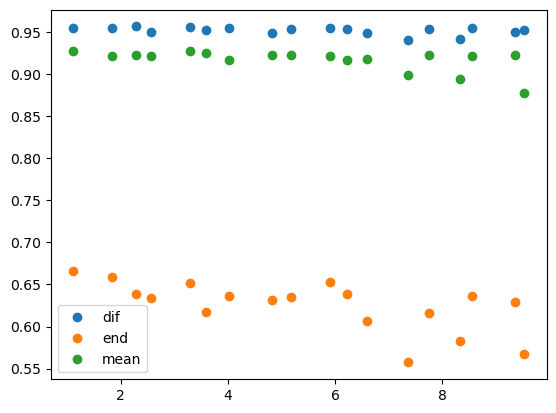

In [51]:
plt.plot(latent[:,0],R2_in.detach().numpy(),'o')
plt.legend(['dif','end','mean'])

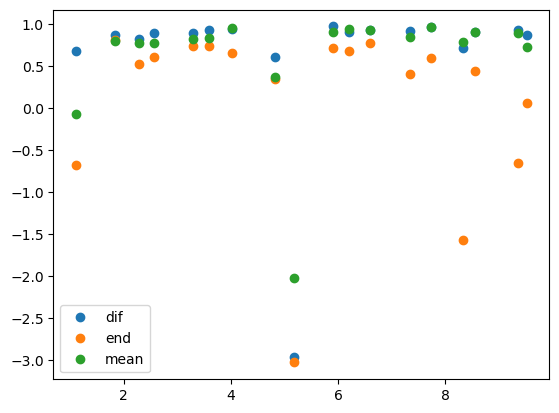

In [52]:
plt.plot(latent[:,0],R2_out[:,:].detach().numpy(),'o')
plt.legend(['dif','end','mean'])

In [53]:
inputs.copy()

[array([[-0.36480013,  0.26540982,  0.59508895],
        [-0.63780544,  0.23032233,  1.13033937],
        [-0.69137445,  0.40455185,  0.01568392],
        [-0.50680934,  0.13353293,  1.64140727],
        [-0.1000718 ,  1.66419939,  0.53109776],
        [-1.42852594,  0.32336028,  1.50455596],
        [-1.26731827,  1.46070894,  1.16218111],
        [-0.99107165,  1.95807459,  1.11811072],
        [-1.46320494,  0.39772591,  1.05779077],
        [-0.29711912,  0.97239898,  0.60719605],
        [-1.21490784,  1.63330867,  0.63512829],
        [-1.07519178,  0.2864253 ,  0.37622463],
        [-1.3993468 ,  1.81607518,  1.89176141],
        [-1.30713827,  0.46451958,  1.86247935],
        [-1.55038099,  0.69629285,  0.87700423],
        [-1.49510311,  1.40016818,  0.91716737],
        [-0.17178317,  1.15060662,  0.69628197],
        [-1.62103337,  0.19703324,  0.50148255],
        [-0.66395347,  1.50352388,  0.29824753],
        [-0.78897706,  0.23381835,  0.53537781],
        [-0.95164256

In [54]:
t_size = 100
reps = 5
MSE = np.zeros((18,17,3))
R2 = np.zeros((18,17,3))
for i in range(18):

    X0 = torch.tensor(inputs[i])
    Y0 = torch.tensor(outputs[i])
    emulator_0 = GPE.ensemble(X0,Y0,mean_func="linear",training_iter=500)
    
    inputs2 = inputs.copy()
    inputs2.pop(i)
    outputs2 = outputs.copy()
    outputs2.pop(i)
    
    for j in (range(17)):
        inputData_1 = inputs2[j]
        outputData_1 = outputs2[j]

        X1 = torch.tensor(inputData_1)
        Y1 = torch.tensor(outputData_1)
        # split original dataset in training, validation and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X1,
            Y1,
            test_size=0.1,
            random_state=seed
        )
        for k in range(reps):
            a=np.random.choice(range(X_train.shape[0]),t_size,replace=False)
            m0 = emulator_0.predict(X_train[a,:])
            y_adjust = torch.tensor(y_train[a] - m0)
            delta_1 = GPE.ensemble(X_train[a,:],y_adjust,mean_func="linear",training_iter=500)
            MSE[i,j,:] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
            R2[i,j,:] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps



0
1
2


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_40209/456847943.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0
1
2


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_40209/456847943.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE[i,j,:] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_40209/456847943.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2[i,j,:] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1


2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0


In [55]:
latent[:,0]

array([8.33018313, 7.35017641, 9.52672745, 6.59588915, 6.21235478,
       2.55906099, 4.82230922, 9.35946918, 3.5966401 , 8.54835852,
       5.17050313, 4.01523671, 2.29078501, 5.89964218, 1.11139346,
       7.742141  , 3.28594304, 1.8315365 ])

In [56]:
R2.mean(axis=1)[:,2]

array([ 0.92807832,  0.19271513, -0.56217223, -0.06917778,  0.34232963,
        0.91575754,  0.94397587,  0.86604569,  0.80707793,  0.90865464,
        0.94484505,  0.47774965,  0.73440141,  0.82924705,  0.91112373,
        0.7099485 ,  0.62697984,  0.9029962 ])

Text(0, 0.5, '$R^2$')

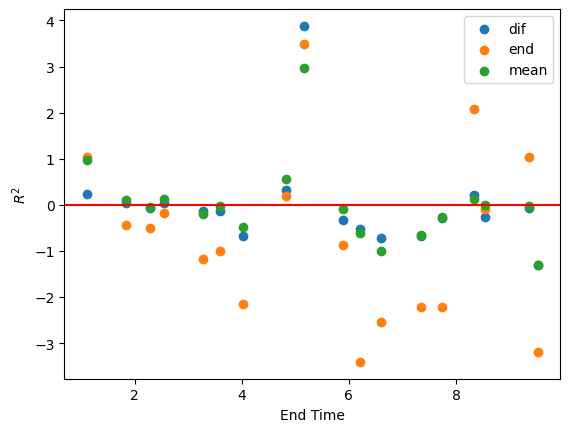

In [57]:
fig, ax = plt.subplots()


ax.scatter(latent[:,0],R2.mean(axis=1)[:,0]-R2_out.detach().numpy()[:,0])
ax.scatter(latent[:,0],R2.mean(axis=1)[:,1]-R2_out.detach().numpy()[:,1])
ax.scatter(latent[:,0],R2.mean(axis=1)[:,2]-R2_out.detach().numpy()[:,2])
plt.axhline(y=0, color='r', linestyle='-')
#ax.scatter(latent[9:,0],R2_out.detach().numpy()[9:,2])

#ax.scatter(latent,R2.mean(axis=1)[:,1])
#ax.scatter(latent,R2_out.detach().numpy()[:,1])

#ax.scatter(latent,R2.mean(axis=1)[:,2])
#ax.scatter(latent,R2_out.detach().numpy()[:,2])

#plt.errorbar(latent,R2.mean(axis=1)[:,0],fmt='o',yerr=R2.std(axis=1)[:,0])


#ax.scatter(latent,R2.mean(axis=1)[:,1])
#plt.errorbar(latent,R2.mean(axis=1)[:,1],fmt='o',yerr=R2.std(axis=1)[:,1])


#ax.scatter(latent,R2.mean(axis=1)[:,2])
#plt.errorbar(latent,R2.mean(axis=1)[:,2],fmt='o',yerr=R2.std(axis=1)[:,2])


plt.legend(['dif','end','mean'])
plt.xlabel('End Time')
plt.ylabel('$R^2$')

Text(0, 0.5, '$R^2$')

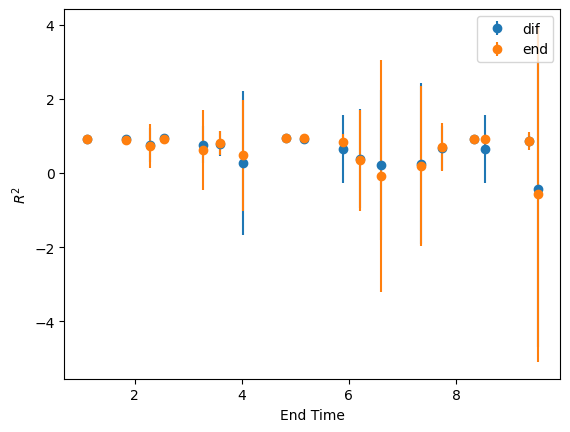

In [58]:
ax.scatter(latent[:,0],R2.mean(axis=1)[:,0])
plt.errorbar(latent[:,0],R2.mean(axis=1)[:,0],fmt='o',yerr=R2.std(axis=1)[:,0])


#ax.scatter(latent[:,0],R2.mean(axis=1)[:,1])
#plt.errorbar(latent[:,0],R2.mean(axis=1)[:,1],fmt='o',yerr=R2.std(axis=1)[:,1])


ax.scatter(latent[:,0],R2.mean(axis=1)[:,2])
plt.errorbar(latent[:,0],R2.mean(axis=1)[:,2],fmt='o',yerr=R2.std(axis=1)[:,2])


plt.legend(['dif','end','mean'])
plt.xlabel('End Time')
plt.ylabel('$R^2$')

In [59]:
X0 = torch.tensor(inputs[0])
Y0 = torch.tensor(outputs[0])

inputData_1 = inputs[1]
outputData_1 = outputs[1]

X1 = torch.tensor(inputData_1)
Y1 = torch.tensor(outputData_1)
# split original dataset in training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X1,
    Y1,
    test_size=0.1,
    random_state=seed
)

emulator_0 = GPE.ensemble(X0,Y0,mean_func="linear",training_iter=500)

0
1
2


In [60]:
def proxy(a,y_train,m0,output):
    a=torch.tensor(a)
    res = ((a*m0-y_train)**2).mean(axis=1).detach().numpy()
    return res[output]

In [61]:
import scipy

In [62]:
m0 = emulator_0.predict(X_train)

In [63]:
proxy(8,y_train,m0,1)

0.009829111436826061

In [64]:
a_d=np.zeros(y_train.shape[1])
for i in range(y_train.shape[1]):
    result = scipy.optimize.minimize(proxy, 1, args=(y_train,m0,i), method='Nelder-Mead', tol=1e-8)
    a_d[i]=result.x
    
a_d=torch.tensor(a_d)

In [65]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0020856217189007954
             x: [ 5.984e+00]
           nit: 35
          nfev: 70
 final_simplex: (array([[ 5.984e+00],
                       [ 5.984e+00]]), array([ 2.086e-03,  2.086e-03]))

In [66]:
t_size = 100
reps = 5
MSE_a = np.zeros((18,17,3))
R2_a = np.zeros((18,17,3))
for i in range(18):

    X0 = torch.tensor(inputs[i])
    Y0 = torch.tensor(outputs[i])
    emulator_0 = GPE.ensemble(X0,Y0,mean_func="linear",training_iter=500)
    
    inputs2 = inputs.copy()
    inputs2.pop(i)
    outputs2 = outputs.copy()
    outputs2.pop(i)
    
    for j in (range(17)):
        inputData_1 = inputs2[j]
        outputData_1 = outputs2[j]

        X1 = torch.tensor(inputData_1)
        Y1 = torch.tensor(outputData_1)
        # split original dataset in training, validation and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X1,
            Y1,
            test_size=0.1,
            random_state=seed
        )
        for k in range(reps):
            a=np.random.choice(range(X_train.shape[0]),t_size,replace=False)
            m0 = emulator_0.predict(X_train[a,:])
            
            a_d=np.zeros(y_train.shape[1])
            for l in range(y_train.shape[1]):
                result = scipy.optimize.minimize(proxy, 1, args=(y_train[a,:],m0,l), method='Nelder-Mead', tol=1e-8)
                print(result.x)
                a_d[l]=result.x

            a_d=torch.tensor(a_d)
            print(a_d)
            
            y_adjust = torch.tensor(y_train[a] - a_d*m0)
            delta_1 = GPE.ensemble(X_train[a,:],y_adjust,mean_func="linear",training_iter=500)
            MSE_a[i,j,:] += np.sqrt(((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
            R2_a[i,j,:] += (1-((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps



0
1
2
[5.21644942]
[5.8049489]
[3.77073874]
tensor([5.2164, 5.8049, 3.7707], dtype=torch.float64)
0


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_40209/3721306800.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - a_d*m0)


1
2


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_40209/3721306800.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_a[i,j,:] += np.sqrt(((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_40209/3721306800.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_a[i,j,:] += (1-((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


[5.65010228]
[5.63210606]
[5.75624911]
tensor([5.6501, 5.6321, 5.7562], dtype=torch.float64)
0
1
2
[5.37988116]
[5.55083873]
[5.55021462]
tensor([5.3799, 5.5508, 5.5502], dtype=torch.float64)
0
1
2
[4.96771657]
[5.32761019]
[5.26616245]
tensor([4.9677, 5.3276, 5.2662], dtype=torch.float64)
0
1
2
[5.60963053]
[5.59072998]
[6.15675263]
tensor([5.6096, 5.5907, 6.1568], dtype=torch.float64)
0
1
2
[7.14312963]
[6.64121773]
[6.91053073]
tensor([7.1431, 6.6412, 6.9105], dtype=torch.float64)
0
1
2
[7.17851596]
[7.18015068]
[7.30019487]
tensor([7.1785, 7.1802, 7.3002], dtype=torch.float64)
0
1
2
[7.26044813]
[7.28958287]
[7.06015271]
tensor([7.2604, 7.2896, 7.0602], dtype=torch.float64)
0
1
2
[6.62918138]
[7.24651241]
[5.94280379]
tensor([6.6292, 7.2465, 5.9428], dtype=torch.float64)
0
1
2
[7.67050712]
[7.52388774]
[7.25881239]
tensor([7.6705, 7.5239, 7.2588], dtype=torch.float64)
0
1
2
[6.82095745]
[7.1727118]
[6.4855732]
tensor([6.8210, 7.1727, 6.4856], dtype=torch.float64)
0
1
2
[6.82097226]

2
[1.6693113]
[2.37475249]
[1.50373517]
tensor([1.6693, 2.3748, 1.5037], dtype=torch.float64)
0
1
2
0
1
2
[0.19058177]
[0.14973476]
[0.17048005]
tensor([0.1906, 0.1497, 0.1705], dtype=torch.float64)
0
1
2
[0.19890108]
[0.18386976]
[0.29455424]
tensor([0.1989, 0.1839, 0.2946], dtype=torch.float64)
0
1
2
[0.17022818]
[0.18556756]
[0.19890135]
tensor([0.1702, 0.1856, 0.1989], dtype=torch.float64)
0
1
2
[0.172757]
[0.16988848]
[0.1659754]
tensor([0.1728, 0.1699, 0.1660], dtype=torch.float64)
0
1
2
[0.17551847]
[0.20837081]
[0.19195678]
tensor([0.1755, 0.2084, 0.1920], dtype=torch.float64)
0
1
2
[1.25865094]
[1.01209779]
[1.33056549]
tensor([1.2587, 1.0121, 1.3306], dtype=torch.float64)
0
1
2
[1.19115525]
[1.24089031]
[1.35174438]
tensor([1.1912, 1.2409, 1.3517], dtype=torch.float64)
0
1
2
[1.27170973]
[1.42224383]
[1.16613696]
tensor([1.2717, 1.4222, 1.1661], dtype=torch.float64)
0
1
2
[1.26211228]
[1.33678339]
[1.42224491]
tensor([1.2621, 1.3368, 1.4222], dtype=torch.float64)
0
1
2
[1.127

[0.28462033]
[0.35305617]
[0.34868043]
tensor([0.2846, 0.3531, 0.3487], dtype=torch.float64)
0
1
2
[0.18467521]
[0.30210823]
[0.37576057]
tensor([0.1847, 0.3021, 0.3758], dtype=torch.float64)
0
1
2
[0.28488398]
[0.38373932]
[0.230384]
tensor([0.2849, 0.3837, 0.2304], dtype=torch.float64)
0
1
2
0
1
2
[0.13627546]
[0.14271443]
[0.13499759]
tensor([0.1363, 0.1427, 0.1350], dtype=torch.float64)
0
1
2
[0.14188379]
[0.13282371]
[0.11436306]
tensor([0.1419, 0.1328, 0.1144], dtype=torch.float64)
0
1
2
[0.14418721]
[0.13617352]
[0.14681924]
tensor([0.1442, 0.1362, 0.1468], dtype=torch.float64)
0
1
2
[0.13791912]
[0.13713537]
[0.14271395]
tensor([0.1379, 0.1371, 0.1427], dtype=torch.float64)
0
1
2
[0.12662793]
[0.14063036]
[0.1158625]
tensor([0.1266, 0.1406, 0.1159], dtype=torch.float64)
0
1
2
[0.77916875]
[0.72003872]
[1.0745761]
tensor([0.7792, 0.7200, 1.0746], dtype=torch.float64)
0
1
2
[0.72723065]
[0.77917188]
[0.74618102]
tensor([0.7272, 0.7792, 0.7462], dtype=torch.float64)
0
1
2
[0.79956

[0.29673783]
[0.22493258]
[0.26156703]
tensor([0.2967, 0.2249, 0.2616], dtype=torch.float64)
0
1
2
[0.18292416]
[0.28298084]
[0.31290108]
tensor([0.1829, 0.2830, 0.3129], dtype=torch.float64)
0
1
2
[0.28516101]
[0.30167557]
[0.11807904]
tensor([0.2852, 0.3017, 0.1181], dtype=torch.float64)
0
1
2
[0.29934738]
[0.30922493]
[0.2949525]
tensor([0.2993, 0.3092, 0.2950], dtype=torch.float64)
0
1
2
[0.28961851]
[0.14689142]
[0.27564103]
tensor([0.2896, 0.1469, 0.2756], dtype=torch.float64)
0
1
2
0
1
2
[0.13753248]
[0.15903078]
[0.13905526]
tensor([0.1375, 0.1590, 0.1391], dtype=torch.float64)
0
1
2
[0.14080395]
[0.14527122]
[0.14433798]
tensor([0.1408, 0.1453, 0.1443], dtype=torch.float64)
0
1
2
[0.14817209]
[0.12940534]
[0.13445827]
tensor([0.1482, 0.1294, 0.1345], dtype=torch.float64)
0
1
2
[0.14094437]
[0.15544962]
[0.15477918]
tensor([0.1409, 0.1554, 0.1548], dtype=torch.float64)
0
1
2
[0.14897026]
[0.14704829]
[0.13518862]
tensor([0.1490, 0.1470, 0.1352], dtype=torch.float64)
0
1
2
[0.79

1
2
[0.3962123]
[0.50547532]
[0.53926057]
tensor([0.3962, 0.5055, 0.5393], dtype=torch.float64)
0
1
2
[0.46977164]
[0.50025897]
[0.43321664]
tensor([0.4698, 0.5003, 0.4332], dtype=torch.float64)
0
1
2
[0.26895556]
[0.18750903]
[0.29601742]
tensor([0.2690, 0.1875, 0.2960], dtype=torch.float64)
0
1
2
[0.36413466]
[0.32416794]
[0.17899798]
tensor([0.3641, 0.3242, 0.1790], dtype=torch.float64)
0
1
2
[0.16148836]
[0.25414808]
[0.2982973]
tensor([0.1615, 0.2541, 0.2983], dtype=torch.float64)
0
1
2
[0.21275381]
[0.29667461]
[0.163787]
tensor([0.2128, 0.2967, 0.1638], dtype=torch.float64)
0
1
2
[0.25188887]
[0.21052526]
[0.20289237]
tensor([0.2519, 0.2105, 0.2029], dtype=torch.float64)
0
1
2
0
1
2
[0.16279949]
[0.16669407]
[0.14649519]
tensor([0.1628, 0.1667, 0.1465], dtype=torch.float64)
0
1
2
[0.13904827]
[0.14267508]
[0.12896606]
tensor([0.1390, 0.1427, 0.1290], dtype=torch.float64)
0
1
2
[0.1329718]
[0.11315576]
[0.1371664]
tensor([0.1330, 0.1132, 0.1372], dtype=torch.float64)
0
1
2
[0.138

1
2
[0.48231425]
[0.53676076]
[0.32167057]
tensor([0.4823, 0.5368, 0.3217], dtype=torch.float64)
0
1
2
[0.53732231]
[0.55036137]
[0.46325535]
tensor([0.5373, 0.5504, 0.4633], dtype=torch.float64)
0
1
2
[0.52549774]
[0.53041432]
[0.46325468]
tensor([0.5255, 0.5304, 0.4633], dtype=torch.float64)
0
1
2
[0.23858106]
[0.19398741]
[0.27221501]
tensor([0.2386, 0.1940, 0.2722], dtype=torch.float64)
0
1
2
[0.33163315]
[0.31706064]
[0.13879822]
tensor([0.3316, 0.3171, 0.1388], dtype=torch.float64)
0
1
2
[0.32810774]
[0.36973656]
[0.33019475]
tensor([0.3281, 0.3697, 0.3302], dtype=torch.float64)
0
1
2
[0.28451376]
[0.3555432]
[0.34983306]
tensor([0.2845, 0.3555, 0.3498], dtype=torch.float64)
0
1
2
[0.29228086]
[0.20702965]
[0.30380528]
tensor([0.2923, 0.2070, 0.3038], dtype=torch.float64)
0
1
2
0
1
2
[0.4551012]
[0.63934312]
[0.57681774]
tensor([0.4551, 0.6393, 0.5768], dtype=torch.float64)
0
1
2
[0.42975668]
[0.59167978]
[0.51761744]
tensor([0.4298, 0.5917, 0.5176], dtype=torch.float64)
0
1
2
[0

1
2
[1.93487791]
[2.07931724]
[1.89367124]
tensor([1.9349, 2.0793, 1.8937], dtype=torch.float64)
0
1
2
[2.55831223]
[2.05695496]
[2.50878374]
tensor([2.5583, 2.0570, 2.5088], dtype=torch.float64)
0
1
2
[2.06682487]
[2.48018001]
[2.43460941]
tensor([2.0668, 2.4802, 2.4346], dtype=torch.float64)
0
1
2
[2.35757998]
[2.69538832]
[1.88661808]
tensor([2.3576, 2.6954, 1.8866], dtype=torch.float64)
0
1
2
[2.03921022]
[1.83229877]
[2.35181878]
tensor([2.0392, 1.8323, 2.3518], dtype=torch.float64)
0
1
2
[1.40732163]
[1.61583571]
[1.38822668]
tensor([1.4073, 1.6158, 1.3882], dtype=torch.float64)
0
1
2
[1.37959594]
[1.55277814]
[1.57916627]
tensor([1.3796, 1.5528, 1.5792], dtype=torch.float64)
0
1
2
[1.23002059]
[1.55517135]
[1.52477608]
tensor([1.2300, 1.5552, 1.5248], dtype=torch.float64)
0
1
2
[1.51956657]
[1.59113373]
[1.36923438]
tensor([1.5196, 1.5911, 1.3692], dtype=torch.float64)
0
1
2
[1.3692337]
[1.37610777]
[1.36112684]
tensor([1.3692, 1.3761, 1.3611], dtype=torch.float64)
0
1
2
0
1
2
[

1
2
[6.02388206]
[6.06616991]
[5.18110361]
tensor([6.0239, 6.0662, 5.1811], dtype=torch.float64)
0
1
2
[6.25811663]
[5.83565563]
[5.75519577]
tensor([6.2581, 5.8357, 5.7552], dtype=torch.float64)
0
1
2
[3.26441221]
[4.27676122]
[3.4308979]
tensor([3.2644, 4.2768, 3.4309], dtype=torch.float64)
0
1
2
[3.78958586]
[3.99384545]
[4.02372298]
tensor([3.7896, 3.9938, 4.0237], dtype=torch.float64)
0
1
2
[2.67620108]
[3.78398476]
[2.35668237]
tensor([2.6762, 3.7840, 2.3567], dtype=torch.float64)
0
1
2
[4.23395822]
[2.80831558]
[4.04200157]
tensor([4.2340, 2.8083, 4.0420], dtype=torch.float64)
0
1
2
[3.82300829]
[3.57484336]
[2.67939181]
tensor([3.8230, 3.5748, 2.6794], dtype=torch.float64)
0
1
2
[1.69655275]
[1.23902906]
[1.02140512]
tensor([1.6966, 1.2390, 1.0214], dtype=torch.float64)
0
1
2
[2.80829998]
[2.20179311]
[1.21144178]
tensor([2.8083, 2.2018, 1.2114], dtype=torch.float64)
0
1
2
[1.14398667]
[2.56242049]
[2.70230841]
tensor([1.1440, 2.5624, 2.7023], dtype=torch.float64)
0
1
2
[2.4580

2
[2.22701875]
[2.41222058]
[2.27154096]
tensor([2.2270, 2.4122, 2.2715], dtype=torch.float64)
0
1
2
[2.20349399]
[2.16677344]
[2.38036521]
tensor([2.2035, 2.1668, 2.3804], dtype=torch.float64)
0
1
2
[2.22701874]
[2.27154036]
[2.08297183]
tensor([2.2270, 2.2715, 2.0830], dtype=torch.float64)
0
1
2
[2.27321898]
[1.92259594]
[2.26411094]
tensor([2.2732, 1.9226, 2.2641], dtype=torch.float64)
0
1
2
[1.18041949]
[1.11629837]
[1.09701245]
tensor([1.1804, 1.1163, 1.0970], dtype=torch.float64)
0
1
2
[1.71326998]
[1.47673246]
[1.41720374]
tensor([1.7133, 1.4767, 1.4172], dtype=torch.float64)
0
1
2
[1.57026415]
[1.1434279]
[1.23783372]
tensor([1.5703, 1.1434, 1.2378], dtype=torch.float64)
0
1
2
[1.01320342]
[1.38897323]
[1.39370341]
tensor([1.0132, 1.3890, 1.3937], dtype=torch.float64)
0
1
2
[1.19423622]
[1.43810042]
[1.45029712]
tensor([1.1942, 1.4381, 1.4503], dtype=torch.float64)
0
1
2
[0.82199535]
[0.86596328]
[0.57098345]
tensor([0.8220, 0.8660, 0.5710], dtype=torch.float64)
0
1
2
[0.865963

1
2
[0.72389382]
[0.62044739]
[0.70190411]
tensor([0.7239, 0.6204, 0.7019], dtype=torch.float64)
0
1
2
[1.12154747]
[1.26358284]
[1.12715555]
tensor([1.1215, 1.2636, 1.1272], dtype=torch.float64)
0
1
2
[0.95562358]
[1.15286023]
[1.09519094]
tensor([0.9556, 1.1529, 1.0952], dtype=torch.float64)
0
1
2
[1.11601852]
[1.15987538]
[1.01867853]
tensor([1.1160, 1.1599, 1.0187], dtype=torch.float64)
0
1
2
[1.13500221]
[1.32691771]
[1.12715603]
tensor([1.1350, 1.3269, 1.1272], dtype=torch.float64)
0
1
2
[1.13005996]
[1.75619601]
[0.95751769]
tensor([1.1301, 1.7562, 0.9575], dtype=torch.float64)
0
1
2
[0.7596491]
[0.77286856]
[0.67044513]
tensor([0.7596, 0.7729, 0.6704], dtype=torch.float64)
0
1
2
[1.02600716]
[0.79640812]
[0.72970659]
tensor([1.0260, 0.7964, 0.7297], dtype=torch.float64)
0
1
2
[0.7378168]
[0.76962643]
[0.83401554]
tensor([0.7378, 0.7696, 0.8340], dtype=torch.float64)
0
1
2
[0.77655736]
[0.77347693]
[0.82709976]
tensor([0.7766, 0.7735, 0.8271], dtype=torch.float64)
0
1
2
[0.82709

1
2
[0.68261535]
[0.84177092]
[0.78151231]
tensor([0.6826, 0.8418, 0.7815], dtype=torch.float64)
0
1
2
[0.88016289]
[0.69634253]
[0.63885998]
tensor([0.8802, 0.6963, 0.6389], dtype=torch.float64)
0
1
2
[0.34652307]
[0.58693396]
[0.83582622]
tensor([0.3465, 0.5869, 0.8358], dtype=torch.float64)
0
1
2
[1.4786666]
[1.44976552]
[1.47999728]
tensor([1.4787, 1.4498, 1.4800], dtype=torch.float64)
0
1
2
[1.53292387]
[1.39933904]
[1.37074236]
tensor([1.5329, 1.3993, 1.3707], dtype=torch.float64)
0
1
2
[1.49117337]
[1.38298047]
[1.58229234]
tensor([1.4912, 1.3830, 1.5823], dtype=torch.float64)
0
1
2
[1.48018827]
[1.60087743]
[1.48000235]
tensor([1.4802, 1.6009, 1.4800], dtype=torch.float64)
0
1
2
[1.61553489]
[1.27136748]
[1.4249726]
tensor([1.6155, 1.2714, 1.4250], dtype=torch.float64)
0
1
2
[1.07477738]
[0.75965556]
[0.96527183]
tensor([1.0748, 0.7597, 0.9653], dtype=torch.float64)
0
1
2
[1.03393828]
[1.05730162]
[1.06282641]
tensor([1.0339, 1.0573, 1.0628], dtype=torch.float64)
0
1
2
[0.93627

1
2
[11.95042062]
[11.70728587]
[12.26101162]
tensor([11.9504, 11.7073, 12.2610], dtype=torch.float64)
0
1
2
[10.68542162]
[10.97226886]
[11.25796998]
tensor([10.6854, 10.9723, 11.2580], dtype=torch.float64)
0
1
2
[3.06919432]
[4.25714488]
[6.18068984]
tensor([3.0692, 4.2571, 6.1807], dtype=torch.float64)
0
1
2
[7.22003331]
[6.44639173]
[5.40199968]
tensor([7.2200, 6.4464, 5.4020], dtype=torch.float64)
0
1
2
[3.90728098]
[6.18887596]
[6.54893738]
tensor([3.9073, 6.1889, 6.5489], dtype=torch.float64)
0
1
2
[4.99896231]
[3.28827056]
[6.72905824]
tensor([4.9990, 3.2883, 6.7291], dtype=torch.float64)
0
1
2
[3.65680418]
[4.99741734]
[6.36433098]
tensor([3.6568, 4.9974, 6.3643], dtype=torch.float64)
0
1
2
[12.08117262]
[12.84432182]
[13.02880201]
tensor([12.0812, 12.8443, 13.0288], dtype=torch.float64)
0
1
2
[9.70857544]
[12.75931938]
[11.50343745]
tensor([ 9.7086, 12.7593, 11.5034], dtype=torch.float64)
0
1
2
[14.17974746]
[12.22976638]
[10.9704962]
tensor([14.1797, 12.2298, 10.9705], dtype

1
2
[0.61316767]
[0.65184182]
[0.83483677]
tensor([0.6132, 0.6518, 0.8348], dtype=torch.float64)
0
1
2
[0.69254407]
[0.64802089]
[0.77138176]
tensor([0.6925, 0.6480, 0.7714], dtype=torch.float64)
0
1
2
[0.54186931]
[0.67858083]
[0.77138208]
tensor([0.5419, 0.6786, 0.7714], dtype=torch.float64)
0
1
2
[0.78788176]
[0.71568498]
[0.83105962]
tensor([0.7879, 0.7157, 0.8311], dtype=torch.float64)
0
1
2
[0.2165139]
[0.35006818]
[0.42397441]
tensor([0.2165, 0.3501, 0.4240], dtype=torch.float64)
0
1
2
[0.31463482]
[0.26762968]
[0.27175841]
tensor([0.3146, 0.2676, 0.2718], dtype=torch.float64)
0
1
2
[0.33671057]
[0.28682661]
[0.19136646]
tensor([0.3367, 0.2868, 0.1914], dtype=torch.float64)
0
1
2
[0.33769906]
[0.36985528]
[0.207364]
tensor([0.3377, 0.3699, 0.2074], dtype=torch.float64)
0
1
2
[0.3755641]
[0.20156125]
[0.1714741]
tensor([0.3756, 0.2016, 0.1715], dtype=torch.float64)
0
1
2
[0.7353946]
[0.83240773]
[0.74298199]
tensor([0.7354, 0.8324, 0.7430], dtype=torch.float64)
0
1
2
[0.63938205]

1
2
[0.73395815]
[0.59889283]
[0.82558749]
tensor([0.7340, 0.5989, 0.8256], dtype=torch.float64)
0
1
2
[0.67011907]
[0.79310886]
[0.61169638]
tensor([0.6701, 0.7931, 0.6117], dtype=torch.float64)
0
1
2
[0.53822882]
[0.80617599]
[0.81971319]
tensor([0.5382, 0.8062, 0.8197], dtype=torch.float64)
0
1
2
[0.82558811]
[0.90124411]
[0.55192013]
tensor([0.8256, 0.9012, 0.5519], dtype=torch.float64)
0
1
2
[0.78083321]
[0.46767401]
[0.63648484]
tensor([0.7808, 0.4677, 0.6365], dtype=torch.float64)
0
1
2
[0.61451993]
[0.47126677]
[0.55180749]
tensor([0.6145, 0.4713, 0.5518], dtype=torch.float64)
0
1
2
[0.67268679]
[0.35408356]
[0.62844831]
tensor([0.6727, 0.3541, 0.6284], dtype=torch.float64)
0
1
2
[0.55470092]
[0.6125686]
[0.38068565]
tensor([0.5547, 0.6126, 0.3807], dtype=torch.float64)
0
1
2
[0.59943711]
[0.47094019]
[0.41631272]
tensor([0.5994, 0.4709, 0.4163], dtype=torch.float64)
0
1
2
[0.55514396]
[0.28253948]
[0.48502226]
tensor([0.5551, 0.2825, 0.4850], dtype=torch.float64)
0
1
2
[0.9998

1
2
[1.29995726]
[1.37528514]
[1.35056466]
tensor([1.3000, 1.3753, 1.3506], dtype=torch.float64)
0
1
2
[1.32629334]
[1.49590368]
[1.35956985]
tensor([1.3263, 1.4959, 1.3596], dtype=torch.float64)
0
1
2
[0.7095088]
[1.09741302]
[1.01438653]
tensor([0.7095, 1.0974, 1.0144], dtype=torch.float64)
0
1
2
[1.10538436]
[0.45771744]
[1.12508093]
tensor([1.1054, 0.4577, 1.1251], dtype=torch.float64)
0
1
2
[0.86910653]
[0.57524076]
[0.96866764]
tensor([0.8691, 0.5752, 0.9687], dtype=torch.float64)
0
1
2
[1.15471897]
[1.12388232]
[0.54391856]
tensor([1.1547, 1.1239, 0.5439], dtype=torch.float64)
0
1
2
[1.10538361]
[0.50689152]
[0.95749714]
tensor([1.1054, 0.5069, 0.9575], dtype=torch.float64)
0
1
2
[0.4682859]
[0.54669048]
[0.65352263]
tensor([0.4683, 0.5467, 0.6535], dtype=torch.float64)
0
1
2
[0.56105881]
[0.40122052]
[0.53898857]
tensor([0.5611, 0.4012, 0.5390], dtype=torch.float64)
0
1
2
[0.27671022]
[0.5568971]
[0.55120201]
tensor([0.2767, 0.5569, 0.5512], dtype=torch.float64)
0
1
2
[0.531639

1
2
[2.66323814]
[1.78017559]
[1.86853479]
tensor([2.6632, 1.7802, 1.8685], dtype=torch.float64)
0
1
2
[3.27047973]
[1.40195272]
[1.34793355]
tensor([3.2705, 1.4020, 1.3479], dtype=torch.float64)
0
1
2
[1.55851669]
[1.47249727]
[1.28741136]
tensor([1.5585, 1.4725, 1.2874], dtype=torch.float64)
0
1
2
[1.56149997]
[2.17651681]
[2.1661646]
tensor([1.5615, 2.1765, 2.1662], dtype=torch.float64)
0
1
2
[1.47445393]
[2.05346631]
[1.84487385]
tensor([1.4745, 2.0535, 1.8449], dtype=torch.float64)
0
1
2
[1.47255206]
[3.35961351]
[1.41474918]
tensor([1.4726, 3.3596, 1.4147], dtype=torch.float64)
0
1
2
[1.40053251]
[1.40821888]
[2.48219235]
tensor([1.4005, 1.4082, 2.4822], dtype=torch.float64)
0
1
2
[2.21742703]
[1.68463206]
[1.47255075]
tensor([2.2174, 1.6846, 1.4726], dtype=torch.float64)
0
1
2
[1.63733991]
[2.37010159]
[1.05618382]
tensor([1.6373, 2.3701, 1.0562], dtype=torch.float64)
0
1
2
[0.91501954]
[1.1618268]
[1.43209602]
tensor([0.9150, 1.1618, 1.4321], dtype=torch.float64)
0
1
2
[1.30505

1
2
[0.07356124]
[0.07376801]
[0.0771683]
tensor([0.0736, 0.0738, 0.0772], dtype=torch.float64)
0
1
2
[1.21401783]
[0.96215982]
[0.6288243]
tensor([1.2140, 0.9622, 0.6288], dtype=torch.float64)
0
1
2
[1.29912429]
[1.19819303]
[1.27521639]
tensor([1.2991, 1.1982, 1.2752], dtype=torch.float64)
0
1
2
[1.270828]
[1.29380384]
[1.01077167]
tensor([1.2708, 1.2938, 1.0108], dtype=torch.float64)
0
1
2
[0.83153472]
[1.03369005]
[0.62882381]
tensor([0.8315, 1.0337, 0.6288], dtype=torch.float64)
0
1
2
[1.21401774]
[1.27410674]
[1.30804935]
tensor([1.2140, 1.2741, 1.3080], dtype=torch.float64)
0
1
2
[0.87586211]
[1.08248901]
[0.98422042]
tensor([0.8759, 1.0825, 0.9842], dtype=torch.float64)
0
1
2
[0.6766722]
[0.79679562]
[0.87229059]
tensor([0.6767, 0.7968, 0.8723], dtype=torch.float64)
0
1
2
[0.82116418]
[0.91739366]
[1.12656808]
tensor([0.8212, 0.9174, 1.1266], dtype=torch.float64)
0
1
2
[1.02837396]
[0.69656135]
[0.67191353]
tensor([1.0284, 0.6966, 0.6719], dtype=torch.float64)
0
1
2
[1.03437696

1
2
[0.11724354]
[0.09977586]
[0.11862925]
tensor([0.1172, 0.0998, 0.1186], dtype=torch.float64)
0
1
2
[0.09491208]
[0.12984288]
[0.10821597]
tensor([0.0949, 0.1298, 0.1082], dtype=torch.float64)
0
1
2
[0.12872421]
[0.09927842]
[0.13112189]
tensor([0.1287, 0.0993, 0.1311], dtype=torch.float64)
0
1
2
[1.75037017]
[1.69385512]
[1.77135386]
tensor([1.7504, 1.6939, 1.7714], dtype=torch.float64)
0
1
2
[1.84345299]
[2.28262199]
[1.80556947]
tensor([1.8435, 2.2826, 1.8056], dtype=torch.float64)
0
1
2
[1.74020288]
[1.80557202]
[2.02030042]
tensor([1.7402, 1.8056, 2.0203], dtype=torch.float64)
0
1
2
[2.10492468]
[1.83511629]
[2.44149393]
tensor([2.1049, 1.8351, 2.4415], dtype=torch.float64)
0
1
2
[1.69385401]
[1.78226812]
[1.56958234]
tensor([1.6939, 1.7823, 1.5696], dtype=torch.float64)
0
1
2
[1.56119529]
[1.3010537]
[1.41406546]
tensor([1.5612, 1.3011, 1.4141], dtype=torch.float64)
0
1
2
[1.56397115]
[1.60725988]
[1.58302985]
tensor([1.5640, 1.6073, 1.5830], dtype=torch.float64)
0
1
2
[1.1796

1
2
[0.14398139]
[0.14603708]
[0.17440627]
tensor([0.1440, 0.1460, 0.1744], dtype=torch.float64)
0
1
2
[0.14184528]
[0.10717396]
[0.10836781]
tensor([0.1418, 0.1072, 0.1084], dtype=torch.float64)
0
1
2
[0.10076935]
[0.14734009]
[0.23047869]
tensor([0.1008, 0.1473, 0.2305], dtype=torch.float64)
0
1
2
[0.10065333]
[0.10152682]
[0.10174466]
tensor([0.1007, 0.1015, 0.1017], dtype=torch.float64)
0
1
2
[0.13106826]
[0.18254122]
[0.18731009]
tensor([0.1311, 0.1825, 0.1873], dtype=torch.float64)
0
1
2
[2.79741106]
[2.24791318]
[3.36013209]
tensor([2.7974, 2.2479, 3.3601], dtype=torch.float64)
0
1
2
[1.61052436]
[2.17052193]
[3.37081673]
tensor([1.6105, 2.1705, 3.3708], dtype=torch.float64)
0
1
2
[2.57073476]
[2.39196908]
[2.01270748]
tensor([2.5707, 2.3920, 2.0127], dtype=torch.float64)
0
1
2
[2.01337011]
[3.64148893]
[2.37682629]
tensor([2.0134, 3.6415, 2.3768], dtype=torch.float64)
0
1
2
[2.57073357]
[3.04356705]
[3.17484879]
tensor([2.5707, 3.0436, 3.1748], dtype=torch.float64)
0
1
2
[2.148

In [67]:
y_train.shape[1]

3

In [68]:
a_d

tensor([1.2627, 1.0888, 1.3692], dtype=torch.float64)

In [69]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0009069986358956097
             x: [ 1.369e+00]
           nit: 28
          nfev: 56
 final_simplex: (array([[ 1.369e+00],
                       [ 1.369e+00]]), array([ 9.070e-04,  9.070e-04]))

In [70]:
latent[:,0]

array([8.33018313, 7.35017641, 9.52672745, 6.59588915, 6.21235478,
       2.55906099, 4.82230922, 9.35946918, 3.5966401 , 8.54835852,
       5.17050313, 4.01523671, 2.29078501, 5.89964218, 1.11139346,
       7.742141  , 3.28594304, 1.8315365 ])

In [71]:
R2.mean(axis=1)[:,2]

array([ 0.92807832,  0.19271513, -0.56217223, -0.06917778,  0.34232963,
        0.91575754,  0.94397587,  0.86604569,  0.80707793,  0.90865464,
        0.94484505,  0.47774965,  0.73440141,  0.82924705,  0.91112373,
        0.7099485 ,  0.62697984,  0.9029962 ])

Text(0, 0.5, '$R^2$')

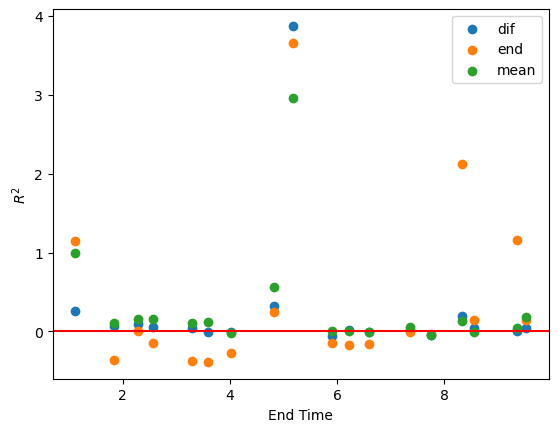

In [72]:
fig, ax = plt.subplots()


ax.scatter(latent[:,0],R2_a.mean(axis=1)[:,0]-R2_out.detach().numpy()[:,0])
ax.scatter(latent[:,0],R2_a.mean(axis=1)[:,1]-R2_out.detach().numpy()[:,1])
ax.scatter(latent[:,0],R2_a.mean(axis=1)[:,2]-R2_out.detach().numpy()[:,2])
plt.axhline(y=0, color='r', linestyle='-')
#ax.scatter(latent[9:,0],R2_out.detach().numpy()[9:,2])

#ax.scatter(latent,R2.mean(axis=1)[:,1])
#ax.scatter(latent,R2_out.detach().numpy()[:,1])

#ax.scatter(latent,R2.mean(axis=1)[:,2])
#ax.scatter(latent,R2_out.detach().numpy()[:,2])

#plt.errorbar(latent,R2.mean(axis=1)[:,0],fmt='o',yerr=R2.std(axis=1)[:,0])


#ax.scatter(latent,R2.mean(axis=1)[:,1])
#plt.errorbar(latent,R2.mean(axis=1)[:,1],fmt='o',yerr=R2.std(axis=1)[:,1])


#ax.scatter(latent,R2.mean(axis=1)[:,2])
#plt.errorbar(latent,R2.mean(axis=1)[:,2],fmt='o',yerr=R2.std(axis=1)[:,2])


plt.legend(['dif','end','mean'])
plt.xlabel('End Time')
plt.ylabel('$R^2$')

Text(0, 0.5, '$R^2$')

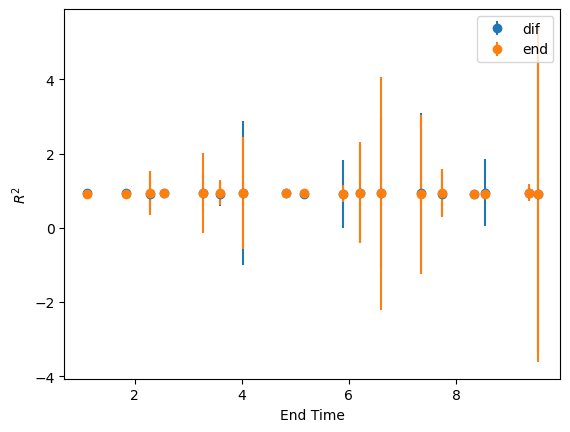

In [73]:
ax.scatter(latent[:,0],R2_a.mean(axis=1)[:,0])
plt.errorbar(latent[:,0],R2_a.mean(axis=1)[:,0],fmt='o',yerr=R2.std(axis=1)[:,0])


#ax.scatter(latent[:,0],R2.mean(axis=1)[:,1])
#plt.errorbar(latent[:,0],R2.mean(axis=1)[:,1],fmt='o',yerr=R2.std(axis=1)[:,1])


ax.scatter(latent[:,0],R2_a.mean(axis=1)[:,2])
plt.errorbar(latent[:,0],R2_a.mean(axis=1)[:,2],fmt='o',yerr=R2.std(axis=1)[:,2])


plt.legend(['dif','end','mean'])
plt.xlabel('End Time')
plt.ylabel('$R^2$')

In [77]:
#b=np.random.choice(range(X_train.shape[0]),18,replace=False)
p = int(X0.shape[0]*0.05)
n = int(X0.shape[0]/p)
m = 18
MSE = np.zeros((n,m,3))
R2 = np.zeros((n,m,3))
reps = 5
for i in range(n):
    for k in range(m):
        for j in range(reps):
            b=np.random.choice(range(X_train.shape[0]),(k+1)*p,replace=False)
            a=np.random.choice(range(X0.shape[0]),(i+1)*p,replace=False)
            emulator_0 = GPE.ensemble(X0[a,:],Y0[a,:],mean_func="linear",training_iter=500)
            m0 = emulator_0.predict(X_train[b,:])
            y_adjust = torch.tensor(y_train[b] - m0)
            delta_1 = GPE.ensemble(X_train[b,:],y_adjust,mean_func="linear",training_iter=500)
            MSE[i,k] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
            R2[i,k] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_40209/1620657441.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[b] - m0)


0
1
2


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_40209/1620657441.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE[i,k] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_40209/1620657441.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2[i,k] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1


2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0


1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2


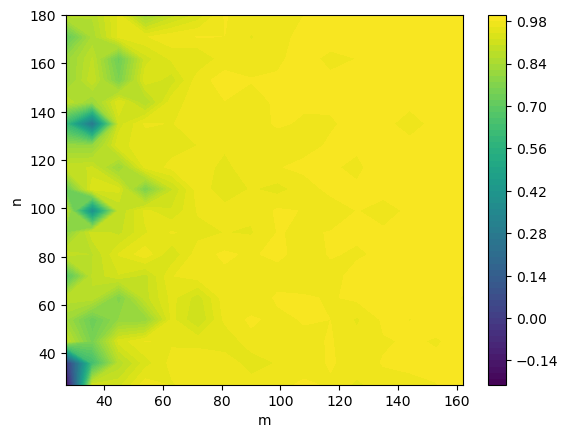

In [89]:
x = np.linspace(9,162,18)

x

y = np.linspace(9,180,20)

y

xx,yy=np.meshgrid(x,y)

xx[1:,1:].shape

level = 2

plt.contourf(xx[level:,level:],yy[level:,level:],R2[level:,level:,2],origin='lower',levels=75)
plt.ylabel('n')
plt.xlabel('m')
plt.colorbar()

In [81]:
#b=np.random.choice(range(X_train.shape[0]),18,replace=False)
p = int(X0.shape[0]*0.05)
n = int(X0.shape[0]/p)
m = 18
MSE_a = np.zeros((n,m,3))
R2_a = np.zeros((n,m,3))
reps = 5
for i in range(n):
    for k in range(m):
        for j in range(reps):
            b=np.random.choice(range(X_train.shape[0]),(k+1)*p,replace=False)
            a=np.random.choice(range(X0.shape[0]),(i+1)*p,replace=False)
            
            m0 = emulator_0.predict(X_train[b,:])
            
            a_d=np.zeros(y_train.shape[1])
            for l in range(y_train.shape[1]):
                result = scipy.optimize.minimize(proxy, 1, args=(y_train[b,:],m0,l), method='Nelder-Mead', tol=1e-8)
                print(result.x)
                a_d[l]=result.x

            a_d=torch.tensor(a_d)
            print(a_d)
            
            emulator_0 = GPE.ensemble(X0[a,:],Y0[a,:],mean_func="linear",training_iter=500)
            m0 = emulator_0.predict(X_train[b,:])
            y_adjust = torch.tensor(y_train[b] - a_d*m0)
            delta_1 = GPE.ensemble(X_train[b,:],y_adjust,mean_func="linear",training_iter=500)
            MSE_a[i,k] += np.sqrt(((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
            R2_a[i,k] += (1-((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


[1.64389087]
[1.41881746]
[2.07479548]
tensor([1.6439, 1.4188, 2.0748], dtype=torch.float64)
0
1
2


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_40209/2370726362.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[b] - a_d*m0)


0
1
2


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_40209/2370726362.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_a[i,k] += np.sqrt(((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_40209/2370726362.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_a[i,k] += (1-((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


[4.17911167]
[1.27137287]
[1.25466624]
tensor([4.1791, 1.2714, 1.2547], dtype=torch.float64)
0
1
2
0
1
2
[2.37299842]
[1.71582886]
[0.97469324]
tensor([2.3730, 1.7158, 0.9747], dtype=torch.float64)
0
1
2
0
1
2
[1.24016714]
[1.22155495]
[1.27097588]
tensor([1.2402, 1.2216, 1.2710], dtype=torch.float64)
0
1
2
0
1
2
[2.68219528]
[1.93406189]
[1.07964244]
tensor([2.6822, 1.9341, 1.0796], dtype=torch.float64)
0
1
2
0
1
2
[2.75108504]
[1.56582799]
[2.54032094]
tensor([2.7511, 1.5658, 2.5403], dtype=torch.float64)
0
1
2
0
1
2
[1.72979243]
[1.47576959]
[1.34436317]
tensor([1.7298, 1.4758, 1.3444], dtype=torch.float64)
0
1
2
0
1
2
[0.92282318]
[1.8431887]
[1.16961519]
tensor([0.9228, 1.8432, 1.1696], dtype=torch.float64)
0
1
2
0
1
2
[0.85079941]
[0.72883434]
[0.74045621]
tensor([0.8508, 0.7288, 0.7405], dtype=torch.float64)
0
1
2
0
1
2
[2.39144342]
[1.60261375]
[1.40755585]
tensor([2.3914, 1.6026, 1.4076], dtype=torch.float64)
0
1
2
0
1
2
[1.37239887]
[1.31598743]
[1.82947671]
tensor([1.3724, 1

1
2
0
1
2
[5.18056035]
[1.19373623]
[1.33766816]
tensor([5.1806, 1.1937, 1.3377], dtype=torch.float64)
0
1
2
0
1
2
[1.2851561]
[1.49161558]
[1.97401082]
tensor([1.2852, 1.4916, 1.9740], dtype=torch.float64)
0
1
2
0
1
2
[1.02017416]
[1.28214126]
[1.15071498]
tensor([1.0202, 1.2821, 1.1507], dtype=torch.float64)
0
1
2
0
1
2
[1.30151957]
[0.73438689]
[1.41552947]
tensor([1.3015, 0.7344, 1.4155], dtype=torch.float64)
0
1
2
0
1
2
[1.10428371]
[0.88427199]
[0.87607139]
tensor([1.1043, 0.8843, 0.8761], dtype=torch.float64)
0
1
2
0
1
2
[0.94979167]
[4.13879714]
[2.06546338]
tensor([0.9498, 4.1388, 2.0655], dtype=torch.float64)
0
1
2
0
1
2
[1.84841921]
[2.00751175]
[0.73072919]
tensor([1.8484, 2.0075, 0.7307], dtype=torch.float64)
0
1
2
0
1
2
[1.18678563]
[0.97748724]
[1.10317395]
tensor([1.1868, 0.9775, 1.1032], dtype=torch.float64)
0
1
2
0
1
2
[1.15978076]
[1.62635841]
[1.18364866]
tensor([1.1598, 1.6264, 1.1836], dtype=torch.float64)
0
1
2
0
1
2
[0.00655024]
[0.95516521]
[0.63844599]
tensor(

1
2
0
1
2
[1.6230823]
[1.75531935]
[1.27714186]
tensor([1.6231, 1.7553, 1.2771], dtype=torch.float64)
0
1
2
0
1
2
[0.98945254]
[1.39476676]
[0.74965327]
tensor([0.9895, 1.3948, 0.7497], dtype=torch.float64)
0
1
2
0
1
2
[0.31259539]
[-0.67288206]
[0.94002297]
tensor([ 0.3126, -0.6729,  0.9400], dtype=torch.float64)
0
1
2
0
1
2
[1.15555977]
[1.39353037]
[1.05955461]
tensor([1.1556, 1.3935, 1.0596], dtype=torch.float64)
0
1
2
0
1
2
[1.06323173]
[1.41087241]
[1.01973097]
tensor([1.0632, 1.4109, 1.0197], dtype=torch.float64)
0
1
2
0
1
2
[2.92416332]
[1.25530663]
[1.34197198]
tensor([2.9242, 1.2553, 1.3420], dtype=torch.float64)
0
1
2
0
1
2
[1.13059186]
[2.15243719]
[1.66492101]
tensor([1.1306, 2.1524, 1.6649], dtype=torch.float64)
0
1
2
0
1
2
[1.25173888]
[5.4874017]
[1.26701136]
tensor([1.2517, 5.4874, 1.2670], dtype=torch.float64)
0
1
2
0
1
2
[1.1823931]
[1.28636077]
[0.8592608]
tensor([1.1824, 1.2864, 0.8593], dtype=torch.float64)
0
1
2
0
1
2
[1.21483077]
[1.21688689]
[1.25071063]
tensor

1
2
0
1
2
[1.07205119]
[1.06633227]
[0.99951206]
tensor([1.0721, 1.0663, 0.9995], dtype=torch.float64)
0
1
2
0
1
2
[1.46564726]
[1.41748456]
[1.07407933]
tensor([1.4656, 1.4175, 1.0741], dtype=torch.float64)
0
1
2
0
1
2
[1.35214263]
[1.13670807]
[1.94904153]
tensor([1.3521, 1.1367, 1.9490], dtype=torch.float64)
0
1
2
0
1
2
[3.21670792]
[1.33732991]
[1.22456208]
tensor([3.2167, 1.3373, 1.2246], dtype=torch.float64)
0
1
2
0
1
2
[0.85578684]
[0.98632973]
[1.1606478]
tensor([0.8558, 0.9863, 1.1606], dtype=torch.float64)
0
1
2
0
1
2
[1.00730098]
[1.54291688]
[1.30637946]
tensor([1.0073, 1.5429, 1.3064], dtype=torch.float64)
0
1
2
0
1
2
[1.93592739]
[1.98005152]
[1.37736669]
tensor([1.9359, 1.9801, 1.3774], dtype=torch.float64)
0
1
2
0
1
2
[1.56804644]
[1.04709998]
[1.24513053]
tensor([1.5680, 1.0471, 1.2451], dtype=torch.float64)
0
1
2
0
1
2
[0.8546784]
[0.02556324]
[0.90470594]
tensor([0.8547, 0.0256, 0.9047], dtype=torch.float64)
0
1
2
0
1
2
[1.19254421]
[1.28214885]
[1.88694119]
tensor([

1
2
0
1
2
[1.36600324]
[2.07273971]
[2.28205086]
tensor([1.3660, 2.0727, 2.2821], dtype=torch.float64)
0
1
2
0
1
2
[1.05613577]
[1.20667846]
[1.65590128]
tensor([1.0561, 1.2067, 1.6559], dtype=torch.float64)
0
1
2
0
1
2
[1.20101541]
[1.23625036]
[0.98045135]
tensor([1.2010, 1.2363, 0.9805], dtype=torch.float64)
0
1
2
0
1
2
[1.02316394]
[1.49510775]
[1.46564807]
tensor([1.0232, 1.4951, 1.4656], dtype=torch.float64)
0
1
2
0
1
2
[1.31756096]
[1.02955501]
[0.976596]
tensor([1.3176, 1.0296, 0.9766], dtype=torch.float64)
0
1
2
0
1
2
[1.57416306]
[0.87257712]
[1.31311011]
tensor([1.5742, 0.8726, 1.3131], dtype=torch.float64)
0
1
2
0
1
2
[1.53389257]
[1.27312869]
[1.27587805]
tensor([1.5339, 1.2731, 1.2759], dtype=torch.float64)
0
1
2
0
1
2
[1.10996324]
[1.20670108]
[1.2686551]
tensor([1.1100, 1.2067, 1.2687], dtype=torch.float64)
0
1
2
0
1
2
[1.0158076]
[1.36726223]
[1.25334484]
tensor([1.0158, 1.3673, 1.2533], dtype=torch.float64)
0
1
2
0
1
2
[0.87091891]
[1.385352]
[0.99893191]
tensor([0.87

1
2
0
1
2
[1.10014505]
[1.47911606]
[1.01452868]
tensor([1.1001, 1.4791, 1.0145], dtype=torch.float64)
0
1
2
0
1
2
[1.24128476]
[1.72654136]
[1.57725213]
tensor([1.2413, 1.7265, 1.5773], dtype=torch.float64)
0
1
2
0
1
2
[1.40567945]
[1.51167974]
[0.97198617]
tensor([1.4057, 1.5117, 0.9720], dtype=torch.float64)
0
1
2
0
1
2
[1.36114789]
[1.98053531]
[1.29414694]
tensor([1.3611, 1.9805, 1.2941], dtype=torch.float64)
0
1
2
0
1
2
[1.23089795]
[1.74092147]
[1.68999176]
tensor([1.2309, 1.7409, 1.6900], dtype=torch.float64)
0
1
2
0
1
2
[1.34549333]
[1.32232917]
[1.04133974]
tensor([1.3455, 1.3223, 1.0413], dtype=torch.float64)
0
1
2
0
1
2
[1.29650728]
[1.51361092]
[2.02803087]
tensor([1.2965, 1.5136, 2.0280], dtype=torch.float64)
0
1
2
0
1
2
[1.49768019]
[1.64189144]
[1.61182108]
tensor([1.4977, 1.6419, 1.6118], dtype=torch.float64)
0
1
2
0
1
2
[0.98182204]
[1.77385443]
[1.84502732]
tensor([0.9818, 1.7739, 1.8450], dtype=torch.float64)
0
1
2
0
1
2
[1.21801525]
[1.31498076]
[1.85412678]
tensor

1
2
0
1
2
[1.44257142]
[1.27300427]
[1.14202418]
tensor([1.4426, 1.2730, 1.1420], dtype=torch.float64)
0
1
2
0
1
2
[1.20019061]
[1.68430235]
[1.43228654]
tensor([1.2002, 1.6843, 1.4323], dtype=torch.float64)
0
1
2
0
1
2
[1.32768285]
[0.95632136]
[1.23728707]
tensor([1.3277, 0.9563, 1.2373], dtype=torch.float64)
0
1
2
0
1
2
[1.16636989]
[1.11656027]
[1.30885096]
tensor([1.1664, 1.1166, 1.3089], dtype=torch.float64)
0
1
2
0
1
2
[1.24448289]
[1.13913977]
[1.33800907]
tensor([1.2445, 1.1391, 1.3380], dtype=torch.float64)
0
1
2
0
1
2
[1.04784884]
[0.97330139]
[1.41992612]
tensor([1.0478, 0.9733, 1.4199], dtype=torch.float64)
0
1
2
0
1
2
[1.26274939]
[2.03167831]
[1.34664904]
tensor([1.2627, 2.0317, 1.3466], dtype=torch.float64)
0
1
2
0
1
2
[1.63816323]
[1.67464581]
[1.13889321]
tensor([1.6382, 1.6746, 1.1389], dtype=torch.float64)
0
1
2
0
1
2
[1.07538887]
[1.04615855]
[1.49091235]
tensor([1.0754, 1.0462, 1.4909], dtype=torch.float64)
0
1
2
0
1
2
[1.32858933]
[1.03830137]
[1.57063453]
tensor

1
2
0
1
2
[1.76953105]
[1.39899532]
[1.44978446]
tensor([1.7695, 1.3990, 1.4498], dtype=torch.float64)
0
1
2
0
1
2
[1.73593058]
[1.09119478]
[0.95285584]
tensor([1.7359, 1.0912, 0.9529], dtype=torch.float64)
0
1
2
0
1
2
[1.31867805]
[1.34153799]
[1.27587675]
tensor([1.3187, 1.3415, 1.2759], dtype=torch.float64)
0
1
2
0
1
2
[1.18473041]
[1.32591869]
[1.10949937]
tensor([1.1847, 1.3259, 1.1095], dtype=torch.float64)
0
1
2
0
1
2
[1.4479363]
[0.91224109]
[1.63119881]
tensor([1.4479, 0.9122, 1.6312], dtype=torch.float64)
0
1
2
0
1
2
[1.77622854]
[1.6549162]
[1.13381478]
tensor([1.7762, 1.6549, 1.1338], dtype=torch.float64)
0
1
2
0
1
2
[1.4314363]
[2.27692304]
[1.10461731]
tensor([1.4314, 2.2769, 1.1046], dtype=torch.float64)
0
1
2
0
1
2
[1.051454]
[1.69113457]
[1.27115874]
tensor([1.0515, 1.6911, 1.2712], dtype=torch.float64)
0
1
2
0
1
2
[1.31297791]
[1.65040306]
[2.17378967]
tensor([1.3130, 1.6504, 2.1738], dtype=torch.float64)
0
1
2
0
1
2
[1.0978728]
[1.0227375]
[1.19631685]
tensor([1.097

1
2
0
1
2
[2.080594]
[2.80519605]
[1.99376719]
tensor([2.0806, 2.8052, 1.9938], dtype=torch.float64)
0
1
2
0
1
2
[1.69855973]
[1.26885916]
[1.33866559]
tensor([1.6986, 1.2689, 1.3387], dtype=torch.float64)
0
1
2
0
1
2
[1.10909309]
[1.36933792]
[1.35915704]
tensor([1.1091, 1.3693, 1.3592], dtype=torch.float64)
0
1
2
0
1
2
[1.60609893]
[1.36457656]
[1.27229772]
tensor([1.6061, 1.3646, 1.2723], dtype=torch.float64)
0
1
2
0
1
2
[0.98655457]
[0.97481517]
[1.3436587]
tensor([0.9866, 0.9748, 1.3437], dtype=torch.float64)
0
1
2
0
1
2
[1.46625093]
[1.3012753]
[3.42835748]
tensor([1.4663, 1.3013, 3.4284], dtype=torch.float64)
0
1
2
0
1
2
[1.26663957]
[1.47694311]
[1.53356777]
tensor([1.2666, 1.4769, 1.5336], dtype=torch.float64)
0
1
2
0
1
2
[1.43414302]
[1.21750787]
[1.66169244]
tensor([1.4341, 1.2175, 1.6617], dtype=torch.float64)
0
1
2
0
1
2
[1.4741582]
[1.09952831]
[1.7855426]
tensor([1.4742, 1.0995, 1.7855], dtype=torch.float64)
0
1
2
0
1
2
[0.98454164]
[1.02848328]
[2.0747181]
tensor([0.984

1
2
0
1
2
[1.64434733]
[1.79741132]
[1.11685543]
tensor([1.6443, 1.7974, 1.1169], dtype=torch.float64)
0
1
2
0
1
2
[2.20664966]
[3.65660591]
[1.13142384]
tensor([2.2066, 3.6566, 1.1314], dtype=torch.float64)
0
1
2
0
1
2
[1.09755446]
[1.3980423]
[1.3805138]
tensor([1.0976, 1.3980, 1.3805], dtype=torch.float64)
0
1
2
0
1
2
[1.27690288]
[1.10132732]
[1.23455212]
tensor([1.2769, 1.1013, 1.2346], dtype=torch.float64)
0
1
2
0
1
2
[1.59098539]
[1.75903628]
[1.67846322]
tensor([1.5910, 1.7590, 1.6785], dtype=torch.float64)
0
1
2
0
1
2
[1.0375586]
[1.39643529]
[1.12540779]
tensor([1.0376, 1.3964, 1.1254], dtype=torch.float64)
0
1
2
0
1
2
[1.24004133]
[1.28324369]
[1.01194332]
tensor([1.2400, 1.2832, 1.0119], dtype=torch.float64)
0
1
2
0
1
2
[1.16654078]
[1.05131899]
[1.06013013]
tensor([1.1665, 1.0513, 1.0601], dtype=torch.float64)
0
1
2
0
1
2
[1.3424896]
[1.11665747]
[2.15155078]
tensor([1.3425, 1.1167, 2.1516], dtype=torch.float64)
0
1
2
0
1
2
[1.57676278]
[1.09696587]
[1.44505595]
tensor([1.

1
2
0
1
2
[1.36487646]
[1.5136683]
[1.45333933]
tensor([1.3649, 1.5137, 1.4533], dtype=torch.float64)
0
1
2
0
1
2
[1.46336826]
[1.33144869]
[1.48823333]
tensor([1.4634, 1.3314, 1.4882], dtype=torch.float64)
0
1
2
0
1
2
[1.27340738]
[1.11200256]
[1.12098569]
tensor([1.2734, 1.1120, 1.1210], dtype=torch.float64)
0
1
2
0
1
2
[2.79927866]
[1.68037149]
[1.28513592]
tensor([2.7993, 1.6804, 1.2851], dtype=torch.float64)
0
1
2
0
1
2
[1.47329329]
[1.09755775]
[0.97290959]
tensor([1.4733, 1.0976, 0.9729], dtype=torch.float64)
0
1
2
0
1
2
[1.16164373]
[1.22838993]
[1.6477346]
tensor([1.1616, 1.2284, 1.6477], dtype=torch.float64)
0
1
2
0
1
2
[1.66967713]
[1.38736023]
[1.41010135]
tensor([1.6697, 1.3874, 1.4101], dtype=torch.float64)
0
1
2
0
1
2
[2.20078182]
[1.04207879]
[1.96452295]
tensor([2.2008, 1.0421, 1.9645], dtype=torch.float64)
0
1
2
0
1
2
[1.37626117]
[1.05643402]
[1.728535]
tensor([1.3763, 1.0564, 1.7285], dtype=torch.float64)
0
1
2
0
1
2
[1.38040739]
[1.05838357]
[1.90984175]
tensor([1.

1
2
0
1
2
[1.66146475]
[1.81440315]
[1.61772023]
tensor([1.6615, 1.8144, 1.6177], dtype=torch.float64)
0
1
2
0
1
2
[1.07457976]
[1.37909602]
[1.39865648]
tensor([1.0746, 1.3791, 1.3987], dtype=torch.float64)
0
1
2
0
1
2
[1.27876672]
[1.54107279]
[1.42918448]
tensor([1.2788, 1.5411, 1.4292], dtype=torch.float64)
0
1
2
0
1
2
[0.90884981]
[1.70504733]
[1.77143947]
tensor([0.9088, 1.7050, 1.7714], dtype=torch.float64)
0
1
2
0
1
2
[1.00955975]
[1.88493612]
[1.38188873]
tensor([1.0096, 1.8849, 1.3819], dtype=torch.float64)
0
1
2
0
1
2
[1.98140782]
[1.5536622]
[1.09246328]
tensor([1.9814, 1.5537, 1.0925], dtype=torch.float64)
0
1
2
0
1
2
[1.55389998]
[1.74210576]
[1.38717177]
tensor([1.5539, 1.7421, 1.3872], dtype=torch.float64)
0
1
2
0
1
2
[1.09485437]
[1.18756983]
[1.39775046]
tensor([1.0949, 1.1876, 1.3978], dtype=torch.float64)
0
1
2
0
1
2
[1.05896706]
[1.00025547]
[1.63366458]
tensor([1.0590, 1.0003, 1.6337], dtype=torch.float64)
0
1
2
0
1
2
[1.19279581]
[1.13888917]
[3.12328618]
tensor(

1
2
0
1
2
[1.32393577]
[1.4464555]
[1.50733581]
tensor([1.3239, 1.4465, 1.5073], dtype=torch.float64)
0
1
2
0
1
2
[1.60059698]
[1.29584088]
[1.79075097]
tensor([1.6006, 1.2958, 1.7908], dtype=torch.float64)
0
1
2
0
1
2
[1.98399159]
[1.44043549]
[1.45736737]
tensor([1.9840, 1.4404, 1.4574], dtype=torch.float64)
0
1
2
0
1
2
[2.0955905]
[1.19071308]
[1.64103264]
tensor([2.0956, 1.1907, 1.6410], dtype=torch.float64)
0
1
2
0
1
2
[1.40246329]
[1.3023605]
[1.05875891]
tensor([1.4025, 1.3024, 1.0588], dtype=torch.float64)
0
1
2
0
1
2
[1.02397984]
[1.01624919]
[1.50225619]
tensor([1.0240, 1.0162, 1.5023], dtype=torch.float64)
0
1
2
0
1
2
[1.43380445]
[1.32985899]
[1.07413529]
tensor([1.4338, 1.3299, 1.0741], dtype=torch.float64)
0
1
2
0
1
2
[1.32260405]
[1.19413084]
[0.93784937]
tensor([1.3226, 1.1941, 0.9378], dtype=torch.float64)
0
1
2
0
1
2
[1.62383422]
[1.12718769]
[1.35820948]
tensor([1.6238, 1.1272, 1.3582], dtype=torch.float64)
0
1
2
0
1
2
[0.9562916]
[1.31911685]
[1.31548883]
tensor([0.

1
2
0
1
2
[1.29777144]
[1.32724814]
[1.51100655]
tensor([1.2978, 1.3272, 1.5110], dtype=torch.float64)
0
1
2
0
1
2
[1.53593099]
[1.12422933]
[1.1569566]
tensor([1.5359, 1.1242, 1.1570], dtype=torch.float64)
0
1
2
0
1
2
[1.45190541]
[1.02174711]
[1.26874077]
tensor([1.4519, 1.0217, 1.2687], dtype=torch.float64)
0
1
2
0
1
2
[1.48178642]
[1.01443281]
[1.08962917]
tensor([1.4818, 1.0144, 1.0896], dtype=torch.float64)
0
1
2
0
1
2
[1.66934847]
[1.0834074]
[0.95194602]
tensor([1.6693, 1.0834, 0.9519], dtype=torch.float64)
0
1
2
0
1
2
[1.24779633]
[1.04752427]
[1.39209104]
tensor([1.2478, 1.0475, 1.3921], dtype=torch.float64)
0
1
2
0
1
2
[1.34317966]
[1.6707566]
[1.70229549]
tensor([1.3432, 1.6708, 1.7023], dtype=torch.float64)
0
1
2
0
1
2
[1.21585769]
[1.7151521]
[1.29749144]
tensor([1.2159, 1.7152, 1.2975], dtype=torch.float64)
0
1
2
0
1
2
[1.08363616]
[1.11782112]
[1.33688924]
tensor([1.0836, 1.1178, 1.3369], dtype=torch.float64)
0
1
2
0
1
2
[1.11294413]
[1.39126914]
[1.66486796]
tensor([1.

1
2
0
1
2
[1.3792587]
[0.9873495]
[1.09815051]
tensor([1.3793, 0.9873, 1.0982], dtype=torch.float64)
0
1
2
0
1
2
[1.27367104]
[1.33226277]
[0.99030246]
tensor([1.2737, 1.3323, 0.9903], dtype=torch.float64)
0
1
2
0
1
2
[1.60110351]
[1.36377007]
[0.93616492]
tensor([1.6011, 1.3638, 0.9362], dtype=torch.float64)
0
1
2
0
1
2
[1.59266787]
[1.07242294]
[1.06546677]
tensor([1.5927, 1.0724, 1.0655], dtype=torch.float64)
0
1
2
0
1
2
[1.49647375]
[1.54863407]
[1.52797674]
tensor([1.4965, 1.5486, 1.5280], dtype=torch.float64)
0
1
2
0
1
2
[1.66869243]
[1.27243621]
[0.93917683]
tensor([1.6687, 1.2724, 0.9392], dtype=torch.float64)
0
1
2
0
1
2
[1.40344176]
[1.6858476]
[1.52444923]
tensor([1.4034, 1.6858, 1.5244], dtype=torch.float64)
0
1
2
0
1
2
[1.02568539]
[1.48996215]
[1.25376478]
tensor([1.0257, 1.4900, 1.2538], dtype=torch.float64)
0
1
2
0
1
2
[1.11151153]
[1.40411707]
[1.40023302]
tensor([1.1115, 1.4041, 1.4002], dtype=torch.float64)
0
1
2
0
1
2
[1.01680565]
[1.37295167]
[1.44751247]
tensor([1

1
2
0
1
2
[1.50359236]
[1.22323067]
[1.23343177]
tensor([1.5036, 1.2232, 1.2334], dtype=torch.float64)
0
1
2
0
1
2
[1.77496308]
[1.02379507]
[1.52116536]
tensor([1.7750, 1.0238, 1.5212], dtype=torch.float64)
0
1
2
0
1
2
[1.75881615]
[1.39024616]
[1.20861663]
tensor([1.7588, 1.3902, 1.2086], dtype=torch.float64)
0
1
2
0
1
2
[1.11322271]
[1.18265176]
[1.26299477]
tensor([1.1132, 1.1827, 1.2630], dtype=torch.float64)
0
1
2
0
1
2
[1.3191734]
[1.68119925]
[1.34638734]
tensor([1.3192, 1.6812, 1.3464], dtype=torch.float64)
0
1
2
0
1
2
[1.37182185]
[1.08693693]
[0.93073074]
tensor([1.3718, 1.0869, 0.9307], dtype=torch.float64)
0
1
2
0
1
2
[1.53790358]
[1.00766873]
[0.97671297]
tensor([1.5379, 1.0077, 0.9767], dtype=torch.float64)
0
1
2
0
1
2
[1.15608331]
[1.21869335]
[1.68473573]
tensor([1.1561, 1.2187, 1.6847], dtype=torch.float64)
0
1
2
0
1
2
[1.66871429]
[1.55816839]
[1.56423466]
tensor([1.6687, 1.5582, 1.5642], dtype=torch.float64)
0
1
2
0
1
2
[1.35317137]
[1.11361351]
[1.55703264]
tensor(

1
2
0
1
2
[1.06408574]
[1.30483847]
[1.44665036]
tensor([1.0641, 1.3048, 1.4467], dtype=torch.float64)
0
1
2
0
1
2
[1.02311903]
[1.02746004]
[1.31412591]
tensor([1.0231, 1.0275, 1.3141], dtype=torch.float64)
0
1
2
0
1
2
[1.32420698]
[0.9830987]
[0.97677577]
tensor([1.3242, 0.9831, 0.9768], dtype=torch.float64)
0
1
2
0
1
2
[1.25296838]
[1.02932788]
[2.13020742]
tensor([1.2530, 1.0293, 2.1302], dtype=torch.float64)
0
1
2
0
1
2
[1.74034455]
[1.0055858]
[1.79367945]
tensor([1.7403, 1.0056, 1.7937], dtype=torch.float64)
0
1
2
0
1
2
[1.07264568]
[1.65387156]
[1.3248821]
tensor([1.0726, 1.6539, 1.3249], dtype=torch.float64)
0
1
2
0
1
2
[1.29644552]
[1.47875531]
[2.12968946]
tensor([1.2964, 1.4788, 2.1297], dtype=torch.float64)
0
1
2
0
1
2
[1.41796597]
[0.97614088]
[1.78355466]
tensor([1.4180, 0.9761, 1.7836], dtype=torch.float64)
0
1
2
0
1
2
[1.17609618]
[1.76439864]
[1.80703473]
tensor([1.1761, 1.7644, 1.8070], dtype=torch.float64)
0
1
2
0
1
2
[1.4059287]
[1.35745914]
[1.72468272]
tensor([1.

1
2
0
1
2
[1.05121795]
[0.94665715]
[1.27272933]
tensor([1.0512, 0.9467, 1.2727], dtype=torch.float64)
0
1
2
0
1
2
[3.75830283]
[1.06656665]
[1.36654365]
tensor([3.7583, 1.0666, 1.3665], dtype=torch.float64)
0
1
2
0
1
2
[1.24462268]
[1.33487416]
[1.33308526]
tensor([1.2446, 1.3349, 1.3331], dtype=torch.float64)
0
1
2
0
1
2
[1.1233858]
[1.32726458]
[1.09471732]
tensor([1.1234, 1.3273, 1.0947], dtype=torch.float64)
0
1
2
0
1
2
[1.91085889]
[1.22525208]
[1.77021843]
tensor([1.9109, 1.2253, 1.7702], dtype=torch.float64)
0
1
2
0
1
2
[1.41389262]
[2.05281071]
[1.22763095]
tensor([1.4139, 2.0528, 1.2276], dtype=torch.float64)
0
1
2
0
1
2
[1.25907975]
[0.92106433]
[1.25491518]
tensor([1.2591, 0.9211, 1.2549], dtype=torch.float64)
0
1
2
0
1
2
[1.70360846]
[2.12845063]
[1.52718914]
tensor([1.7036, 2.1285, 1.5272], dtype=torch.float64)
0
1
2
0
1
2
[2.13421028]
[1.28243849]
[1.1830866]
tensor([2.1342, 1.2824, 1.1831], dtype=torch.float64)
0
1
2
0
1
2
[1.05752002]
[1.34044656]
[1.36324663]
tensor([

1
2
0
1
2
[1.3926794]
[1.41997011]
[1.39787557]
tensor([1.3927, 1.4200, 1.3979], dtype=torch.float64)
0
1
2
0
1
2
[1.46011202]
[2.76864622]
[1.07882484]
tensor([1.4601, 2.7686, 1.0788], dtype=torch.float64)
0
1
2
0
1
2
[1.1487448]
[1.4758444]
[1.32290109]
tensor([1.1487, 1.4758, 1.3229], dtype=torch.float64)
0
1
2
0
1
2
[1.14141538]
[1.2818663]
[1.82771832]
tensor([1.1414, 1.2819, 1.8277], dtype=torch.float64)
0
1
2
0
1
2
[1.04125044]
[1.12571739]
[1.30454762]
tensor([1.0413, 1.1257, 1.3045], dtype=torch.float64)
0
1
2
0
1
2
[1.20074975]
[1.38812521]
[1.25588177]
tensor([1.2007, 1.3881, 1.2559], dtype=torch.float64)
0
1
2
0
1
2
[1.65649171]
[1.30134193]
[1.14033613]
tensor([1.6565, 1.3013, 1.1403], dtype=torch.float64)
0
1
2
0
1
2
[0.9569512]
[1.17386013]
[1.32809169]
tensor([0.9570, 1.1739, 1.3281], dtype=torch.float64)
0
1
2
0
1
2
[1.04772619]
[1.70194414]
[1.09358135]
tensor([1.0477, 1.7019, 1.0936], dtype=torch.float64)
0
1
2
0
1
2
[1.48311365]
[1.53132966]
[1.14951671]
tensor([1.4

1
2
0
1
2
[1.54598895]
[1.28939066]
[1.34422956]
tensor([1.5460, 1.2894, 1.3442], dtype=torch.float64)
0
1
2
0
1
2
[0.92078347]
[1.147276]
[1.40717988]
tensor([0.9208, 1.1473, 1.4072], dtype=torch.float64)
0
1
2
0
1
2
[1.29146996]
[1.10928389]
[1.7784679]
tensor([1.2915, 1.1093, 1.7785], dtype=torch.float64)
0
1
2
0
1
2
[1.07981858]
[1.16140604]
[0.97365927]
tensor([1.0798, 1.1614, 0.9737], dtype=torch.float64)
0
1
2
0
1
2
[0.93020473]
[1.91995509]
[1.40140564]
tensor([0.9302, 1.9200, 1.4014], dtype=torch.float64)
0
1
2
0
1
2
[1.10246453]
[1.35939366]
[1.43886244]
tensor([1.1025, 1.3594, 1.4389], dtype=torch.float64)
0
1
2
0
1
2
[0.96451809]
[0.93742722]
[1.98038507]
tensor([0.9645, 0.9374, 1.9804], dtype=torch.float64)
0
1
2
0
1
2
[1.28848196]
[1.27752928]
[1.57825037]
tensor([1.2885, 1.2775, 1.5783], dtype=torch.float64)
0
1
2
0
1
2
[1.46566622]
[1.43918943]
[1.12127558]
tensor([1.4657, 1.4392, 1.1213], dtype=torch.float64)
0
1
2
0
1
2
[2.00394615]
[1.01209916]
[1.33647812]
tensor([2

1
2
0
1
2
[1.67229363]
[1.22530068]
[1.33336122]
tensor([1.6723, 1.2253, 1.3334], dtype=torch.float64)
0
1
2
0
1
2
[1.29631124]
[1.10437698]
[1.42344653]
tensor([1.2963, 1.1044, 1.4234], dtype=torch.float64)
0
1
2
0
1
2
[1.33391651]
[1.12136681]
[1.49112096]
tensor([1.3339, 1.1214, 1.4911], dtype=torch.float64)
0
1
2
0
1
2
[1.11834196]
[1.47553595]
[1.51904171]
tensor([1.1183, 1.4755, 1.5190], dtype=torch.float64)
0
1
2
0
1
2
[1.41110742]
[1.48679657]
[1.55924456]
tensor([1.4111, 1.4868, 1.5592], dtype=torch.float64)
0
1
2
0
1
2
[1.74305912]
[1.32245249]
[1.77646108]
tensor([1.7431, 1.3225, 1.7765], dtype=torch.float64)
0
1
2
0
1
2
[1.20201609]
[1.38529022]
[1.4537406]
tensor([1.2020, 1.3853, 1.4537], dtype=torch.float64)
0
1
2
0
1
2
[1.2539867]
[1.75629829]
[1.4491672]
tensor([1.2540, 1.7563, 1.4492], dtype=torch.float64)
0
1
2
0
1
2
[1.38962758]
[1.11186426]
[1.34147286]
tensor([1.3896, 1.1119, 1.3415], dtype=torch.float64)
0
1
2
0
1
2
[1.4107638]
[1.4427676]
[1.82015154]
tensor([1.4

1
2
0
1
2
[1.316748]
[1.38572989]
[0.98371453]
tensor([1.3167, 1.3857, 0.9837], dtype=torch.float64)
0
1
2
0
1
2
[1.2092016]
[1.40308801]
[1.47533626]
tensor([1.2092, 1.4031, 1.4753], dtype=torch.float64)
0
1
2
0
1
2
[1.14667441]
[1.61802427]
[1.35799147]
tensor([1.1467, 1.6180, 1.3580], dtype=torch.float64)
0
1
2
0
1
2
[1.20222336]
[0.9796515]
[1.06298594]
tensor([1.2022, 0.9797, 1.0630], dtype=torch.float64)
0
1
2
0
1
2
[0.92975747]
[1.21372427]
[1.46001462]
tensor([0.9298, 1.2137, 1.4600], dtype=torch.float64)
0
1
2
0
1
2
[0.96334121]
[1.89959075]
[0.93684248]
tensor([0.9633, 1.8996, 0.9368], dtype=torch.float64)
0
1
2
0
1
2
[0.89947782]
[1.39744036]
[1.53166147]
tensor([0.8995, 1.3974, 1.5317], dtype=torch.float64)
0
1
2
0
1
2
[1.416063]
[1.99099581]
[1.09850323]
tensor([1.4161, 1.9910, 1.0985], dtype=torch.float64)
0
1
2
0
1
2
[1.73621314]
[0.95592242]
[0.99837099]
tensor([1.7362, 0.9559, 0.9984], dtype=torch.float64)
0
1
2
0
1
2
[1.05268016]
[1.20817356]
[1.4546814]
tensor([1.052

1
2
0
1
2
[1.65884539]
[1.66312699]
[0.98421644]
tensor([1.6588, 1.6631, 0.9842], dtype=torch.float64)
0
1
2
0
1
2
[1.17063553]
[1.21318742]
[1.28339394]
tensor([1.1706, 1.2132, 1.2834], dtype=torch.float64)
0
1
2
0
1
2
[1.73379835]
[1.05857]
[1.32671481]
tensor([1.7338, 1.0586, 1.3267], dtype=torch.float64)
0
1
2
0
1
2
[1.06698819]
[1.35928108]
[1.66993451]
tensor([1.0670, 1.3593, 1.6699], dtype=torch.float64)
0
1
2
0
1
2
[1.13089024]
[2.13169634]
[0.98338413]
tensor([1.1309, 2.1317, 0.9834], dtype=torch.float64)
0
1
2
0
1
2
[1.88631723]
[1.80088967]
[1.91972167]
tensor([1.8863, 1.8009, 1.9197], dtype=torch.float64)
0
1
2
0
1
2
[1.23871109]
[1.73376649]
[1.14823285]
tensor([1.2387, 1.7338, 1.1482], dtype=torch.float64)
0
1
2
0
1
2
[1.28318269]
[1.66292748]
[1.14970044]
tensor([1.2832, 1.6629, 1.1497], dtype=torch.float64)
0
1
2
0
1
2
[1.71200762]
[1.48670268]
[1.12173943]
tensor([1.7120, 1.4867, 1.1217], dtype=torch.float64)
0
1
2
0
1
2
[1.17061253]
[1.29231572]
[1.13598566]
tensor([1

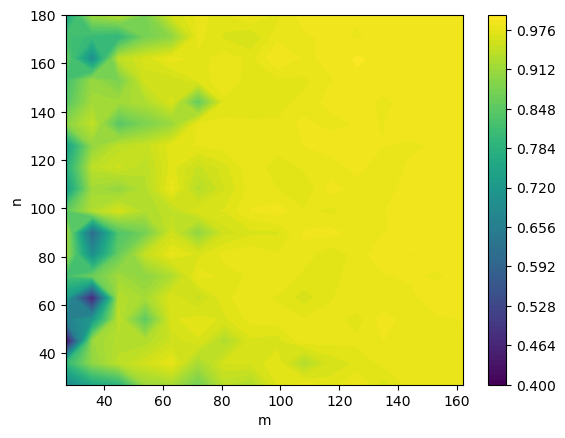

In [90]:
x = np.linspace(9,162,18)

x

y = np.linspace(9,180,20)

y

xx,yy=np.meshgrid(x,y)

xx[1:,1:].shape

level = 2

plt.contourf(xx[level:,level:],yy[level:,level:],R2_a[level:,level:,2],origin='lower',levels=75)
plt.ylabel('n')
plt.xlabel('m')
plt.colorbar()

In [ ]:

ax.scatter(latent[:,1],R2.mean(axis=1)[:,1])
plt.errorbar(latent[:,1],R2.mean(axis=1)[:,0],fmt='o',yerr=R2.std(axis=1)[:,0])


ax.scatter(latent[:,1],R2.mean(axis=1)[:,1])
plt.errorbar(latent[:,1],R2.mean(axis=1)[:,1],fmt='o',yerr=R2.std(axis=1)[:,1])


ax.scatter(latent[:,1],R2.mean(axis=1)[:,2])
plt.errorbar(latent[:,1],R2.mean(axis=1)[:,2],fmt='o',yerr=R2.std(axis=1)[:,2])


plt.legend(['dif','end','mean'])
plt.xlabel('End Time')
plt.ylabel('$R^2$')
#plt.yscale('log')